Input dropout + Sparse

In [1643]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from itertools import product
import pprint


from codes.utils import *
from codes.process import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pp = pprint.PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore') 
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.dpi"] = 300

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'
y_value = 'y'  # Fix for all analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1471]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_X_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [1472]:
# For fold
#fold_num = 1
#in_fold_num = 1

# For model
#learning_rate = 0.01
#sparsity_target = 0.2
#sparsity_weight = 0.3
#dropout_rate = 0.3
#ex_num = 100

# For training
n_epochs = 200
batch_size = 16
#loss_test_min = 1000

In [1475]:
def build_data(fold_num, in_fold_num, hparam, with_iid=False): 
    # Train data
    bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
    bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

    # Test data
    bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=hparam['en'])}.raw",
        delim_whitespace=True)
    bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
    bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
    bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

    # Data set
    if with_iid:
        X_train = bed_data_train
        X_test = bed_data_test
    else:
        X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
    y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
    y_test = bed_data_test[y_value].to_numpy().astype(np.int32)
    
    return X_train, y_train, X_test, y_test

def process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam):
    result_list = []
    
    ##### Init #####
    reset_graph(random_seed)
    training = tf.placeholder_with_default(False, shape=(), name='training')
    n_inputs = X_train.shape[1]
    n_hidden = 10
    n_outputs = n_inputs

    ##### Build Model #####
    # input
    X_input = tf.placeholder(tf.float32, shape=[None, n_inputs])

    # layers
    X_drop = tf.layers.dropout(X_input, hparam['dr'], training=training)  # Input dropout
    hidden2 = tf.layers.dense(X_drop, n_hidden, activation=tf.nn.sigmoid)
    hidden1 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.sigmoid)
    hidden0 = tf.layers.dense(hidden1, 1, activation=tf.nn.sigmoid)
    hidden1r = tf.layers.dense(hidden0, n_hidden, activation=tf.nn.sigmoid)
    hidden2r = tf.layers.dense(hidden1r, n_hidden, activation=tf.nn.sigmoid)
    logits = tf.layers.dense(hidden2r, n_outputs)

    # output
    logits = tf.layers.dense(hidden2r, n_outputs)

    ##### Construct Loss #####
    # sparsity loss
    hidden_mean = tf.reduce_mean([hidden2, hidden1, hidden1r, hidden2r], axis=0)
    sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden_mean))

    # mean info  # Use mae as r_loss
    mae = tf.reduce_mean(tf.abs(logits - X_input))
#    mse = tf.reduce_mean(tf.square(logits-X_input))
#    c_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=X_input, logits=logits))  # cross  entropy 

    # Setting
    r_loss = mae

    # Reconstruction Loss
    loss = r_loss + hparam['sw'] * sparsity_loss

    # Optimizer
    optimizer = tf.train.AdamOptimizer(hparam['lr'])
    training_op = optimizer.minimize(loss)
    
    # Execute TF
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    loss_test_min = 1000
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs+1):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print(f'\r{100 * iteration // n_batches}%', end='')
                #sys.stdout.flush()
                X_batch = next(shuffle_X_batch(X_train, batch_size))
                sess.run(training_op, feed_dict={X_input: X_batch})
            if epoch % 10 == 0:
                mae_train, loss_train = sess.run([mae, loss], feed_dict={X_input: X_batch})
                mae_test, loss_test = sess.run([mae, loss], feed_dict={X_input: X_test})
                print(f'\r{epoch} Train, \tMAE: {mae_train: 4f}, \tLoss:, {loss_train:.4f}')
                print(f'\r{epoch} Test, \tMAE: {mae_test: 4f}, \tLoss:, {loss_test:.4f}')
                result_list.append([[epoch, fold_num, in_fold_num, hparam, mae_train, loss_train],
                                    [epoch, fold_num, in_fold_num, hparam, mae_test, loss_test]])
                if (loss_test_min > loss_test and epoch > 0) or epoch ==10:
                    loss_test_min = loss_test
                    saver.save(sess, get_bed_path('model_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value,
                                                  ex=hparam['en'], model_key=get_model_key(hparam), epoch=epoch))
                    print('Save model!')
                
    return result_list

def process_model(fold_num, in_fold_num, hparam):
    X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
    result_list = process_network(X_train, y_train, X_test, y_test, fold_num, in_fold_num, hparam)

    return result_list

In [1476]:
%%time
lr_list = [0.01]
st_list = [0.5]
sw_list = [0.5]
dr_list = [0.5]
#en_list = [100, 1000, 10000]
en_list = [100]

hdict = {}
# Find Hyper parameter
reset_graph()
for prod_num, prod_set in enumerate(product(*[lr_list, st_list, sw_list, dr_list, en_list])):
    hparam ={}
    hparam['lr'], hparam['st'], hparam['sw'], hparam['dr'], hparam['en'] = prod_set
    hcv_result = []    
    for fold_num in range(1,6):
#        for in_fold_num in ([None] + list(range(1,6))):
        for in_fold_num in ([None]):
            print(fold_num, in_fold_num)
            hcv_result.append(process_model(fold_num, in_fold_num, hparam))
    hdict[prod_num] = hcv_result  # prod_num -> [[[epoch train], [epoch test]]]

1 None
0 Train, 	MAE:  0.184485, 	Loss:, 0.1924
0 Test, 	MAE:  0.176694, 	Loss:, 1.3012
10 Train, 	MAE:  0.078711, 	Loss:, 0.0852
10 Test, 	MAE:  0.071626, 	Loss:, 0.4377
Save model!
20 Train, 	MAE:  0.054496, 	Loss:, 0.0550
20 Test, 	MAE:  0.052332, 	Loss:, 0.0901
Save model!
30 Train, 	MAE:  0.046643, 	Loss:, 0.0469
30 Test, 	MAE:  0.053139, 	Loss:, 0.0745
Save model!
40 Train, 	MAE:  0.073629, 	Loss:, 0.0739
40 Test, 	MAE:  0.059369, 	Loss:, 0.0759
50 Train, 	MAE:  0.037534, 	Loss:, 0.0452
50 Test, 	MAE:  0.050795, 	Loss:, 0.1180
60 Train, 	MAE:  0.055379, 	Loss:, 0.0555
60 Test, 	MAE:  0.057886, 	Loss:, 0.0693
Save model!
70 Train, 	MAE:  0.065549, 	Loss:, 0.0656
70 Test, 	MAE:  0.052456, 	Loss:, 0.1622
80 Train, 	MAE:  0.040589, 	Loss:, 0.0406
80 Test, 	MAE:  0.057449, 	Loss:, 0.0676
Save model!
90 Train, 	MAE:  0.040045, 	Loss:, 0.0407
90 Test, 	MAE:  0.054893, 	Loss:, 0.0826
100 Train, 	MAE:  0.056195, 	Loss:, 0.0563
100 Test, 	MAE:  0.051157, 	Loss:, 0.0863
110 Train, 	MAE:  0.

0 Train, 	MAE:  0.181166, 	Loss:, 0.1815
0 Test, 	MAE:  0.193036, 	Loss:, 0.3642
10 Train, 	MAE:  0.226131, 	Loss:, 0.2262
10 Test, 	MAE:  0.192799, 	Loss:, 0.2304
Save model!
20 Train, 	MAE:  0.181198, 	Loss:, 0.1812
20 Test, 	MAE:  0.192091, 	Loss:, 0.2029
Save model!
30 Train, 	MAE:  0.202075, 	Loss:, 0.2021
30 Test, 	MAE:  0.191990, 	Loss:, 0.1969
Save model!
40 Train, 	MAE:  0.196586, 	Loss:, 0.1966
40 Test, 	MAE:  0.191679, 	Loss:, 0.1959
Save model!
50 Train, 	MAE:  0.228207, 	Loss:, 0.2282
50 Test, 	MAE:  0.191682, 	Loss:, 0.1929
Save model!
60 Train, 	MAE:  0.216934, 	Loss:, 0.2170
60 Test, 	MAE:  0.191547, 	Loss:, 0.1927
Save model!
70 Train, 	MAE:  0.211040, 	Loss:, 0.2110
70 Test, 	MAE:  0.191451, 	Loss:, 0.1922
Save model!
80 Train, 	MAE:  0.097279, 	Loss:, 0.0983
80 Test, 	MAE:  0.091414, 	Loss:, 0.1304
Save model!
90 Train, 	MAE:  0.077681, 	Loss:, 0.0778
90 Test, 	MAE:  0.079199, 	Loss:, 0.0864
Save model!
100 Train, 	MAE:  0.066072, 	Loss:, 0.0662
100 Test, 	MAE:  0.07

160 Train, 	MAE:  0.128733, 	Loss:, 0.1298
160 Test, 	MAE:  0.100894, 	Loss:, 0.1661
170 Train, 	MAE:  0.153215, 	Loss:, 0.1541
170 Test, 	MAE:  0.168961, 	Loss:, 0.2022
180 Train, 	MAE:  0.120054, 	Loss:, 0.1204
180 Test, 	MAE:  0.115122, 	Loss:, 0.1372
190 Train, 	MAE:  0.082415, 	Loss:, 0.0828
190 Test, 	MAE:  0.118030, 	Loss:, 0.1461
200 Train, 	MAE:  0.158323, 	Loss:, 0.1593
200 Test, 	MAE:  0.176316, 	Loss:, 0.2346
4 None
0 Train, 	MAE:  0.085525, 	Loss:, 0.0963
0 Test, 	MAE:  0.092851, 	Loss:, 0.7892
10 Train, 	MAE:  0.095209, 	Loss:, 0.0957
10 Test, 	MAE:  0.092547, 	Loss:, 0.1592
Save model!
20 Train, 	MAE:  0.050818, 	Loss:, 0.0512
20 Test, 	MAE:  0.055576, 	Loss:, 0.0913
Save model!
30 Train, 	MAE:  0.054147, 	Loss:, 0.0543
30 Test, 	MAE:  0.055432, 	Loss:, 0.0721
Save model!
40 Train, 	MAE:  0.045742, 	Loss:, 0.0460
40 Test, 	MAE:  0.054916, 	Loss:, 0.0713
Save model!
50 Train, 	MAE:  0.040166, 	Loss:, 0.0403
50 Test, 	MAE:  0.055650, 	Loss:, 0.0676
Save model!
60 Train, 	M

0 Train, 	MAE:  0.136420, 	Loss:, 0.1836
0 Test, 	MAE:  0.209460, 	Loss:, 1.4877
10 Train, 	MAE:  0.089673, 	Loss:, 0.1020
10 Test, 	MAE:  0.096649, 	Loss:, 0.7903
Save model!
20 Train, 	MAE:  0.076661, 	Loss:, 0.0773
20 Test, 	MAE:  0.064329, 	Loss:, 0.1174
Save model!
30 Train, 	MAE:  0.057235, 	Loss:, 0.0581
30 Test, 	MAE:  0.063955, 	Loss:, 0.0822
Save model!
40 Train, 	MAE:  0.054289, 	Loss:, 0.0544
40 Test, 	MAE:  0.068871, 	Loss:, 0.1145
50 Train, 	MAE:  0.047155, 	Loss:, 0.0473
50 Test, 	MAE:  0.061087, 	Loss:, 0.0885
60 Train, 	MAE:  0.045754, 	Loss:, 0.0458
60 Test, 	MAE:  0.065068, 	Loss:, 0.1092
70 Train, 	MAE:  0.082773, 	Loss:, 0.0829
70 Test, 	MAE:  0.063360, 	Loss:, 0.0728
Save model!
80 Train, 	MAE:  0.043160, 	Loss:, 0.0432
80 Test, 	MAE:  0.061479, 	Loss:, 0.0677
Save model!
90 Train, 	MAE:  0.076195, 	Loss:, 0.0767
90 Test, 	MAE:  0.061525, 	Loss:, 0.0697
100 Train, 	MAE:  0.054637, 	Loss:, 0.0554
100 Test, 	MAE:  0.069934, 	Loss:, 0.1123
110 Train, 	MAE:  0.062975,

In [ ]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count with Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

Text(0, 0.5, 'MAE')

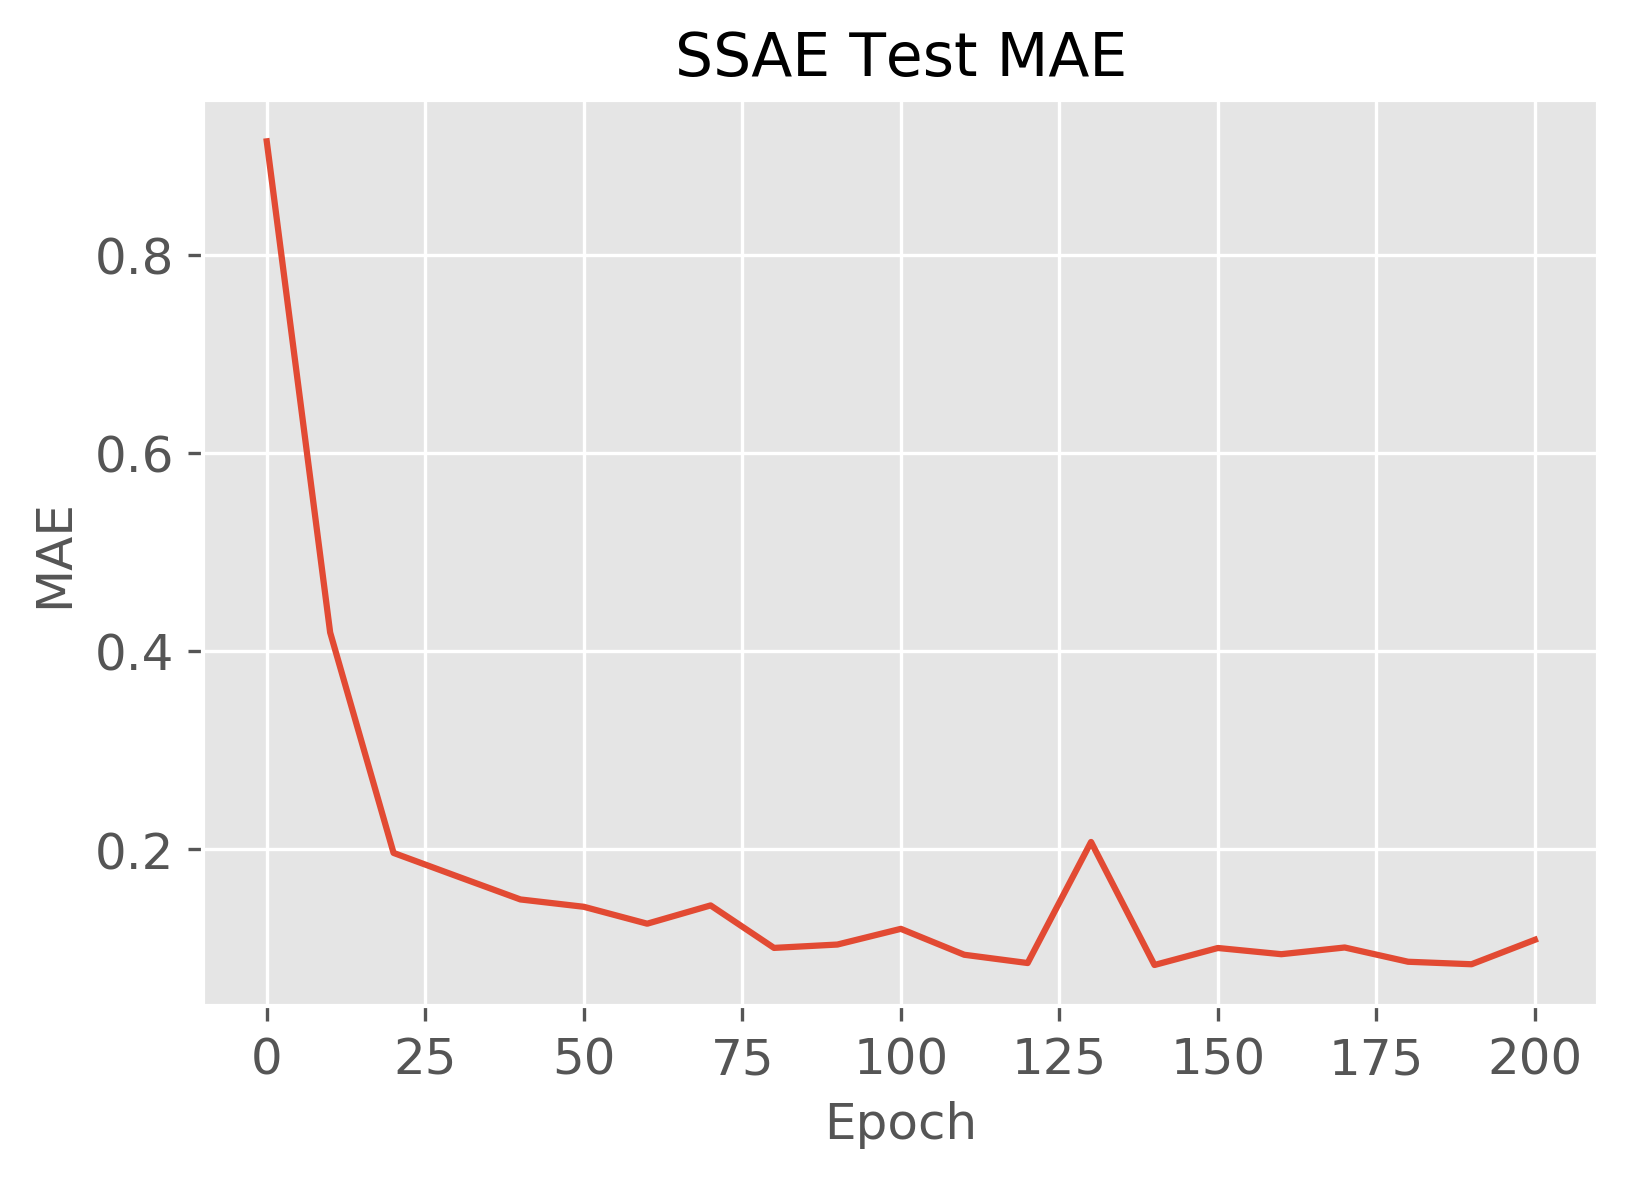

In [1586]:
epoch = [x*10 for x in range(21)]
plt.figure(dpi=300)
plt.plot(epoch, epoch_mae)
plt.title('SSAE Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')

Text(0, 0.5, 'Loss')

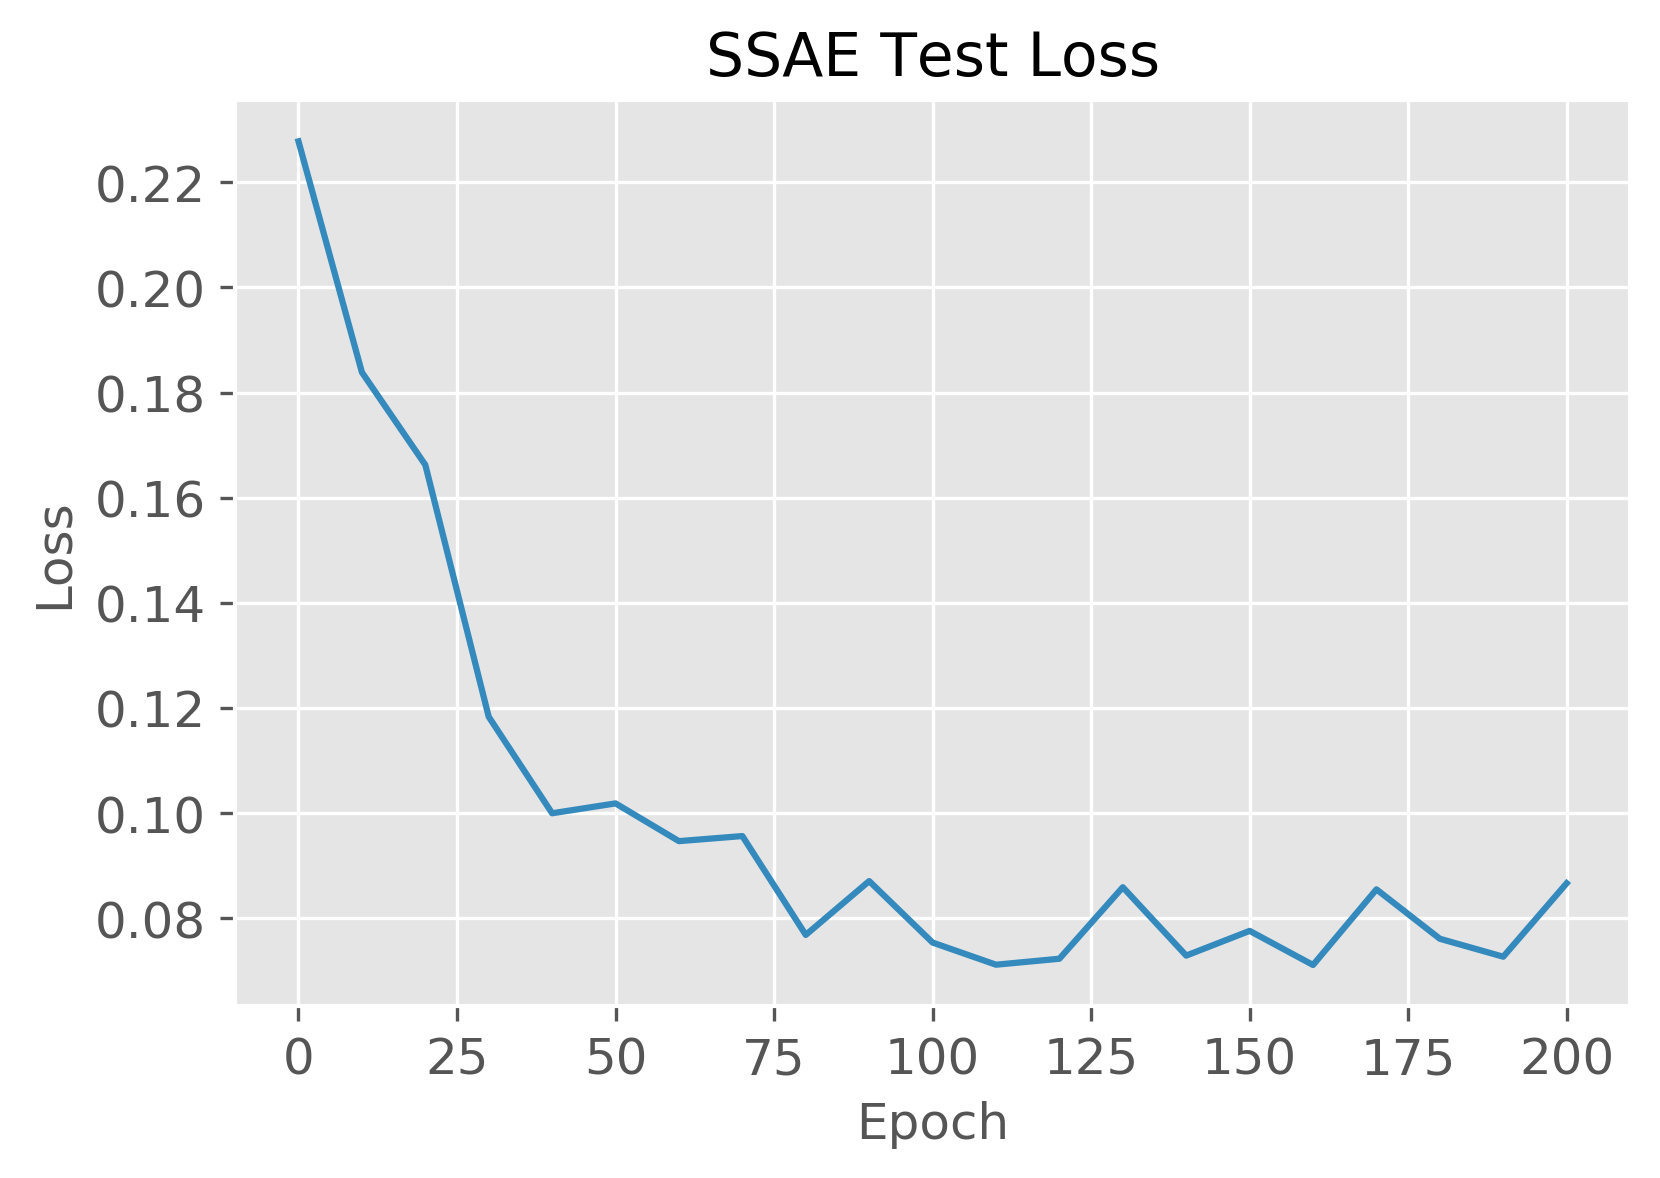

In [1589]:
epoch = [x*10 for x in range(21)]
plt.figure(dpi=300)
plt.plot(epoch, epoch_loss, c='#348abd')
plt.title('SSAE Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [1567]:
epoch_loss = np.mean([[epoch_i[1][4] for epoch_i in fold_i] for fold_i in hdict[0]], axis=0)  # loss by epoch
epoch_mae = np.mean([[epoch_i[1][5] for epoch_i in fold_i] for fold_i in hdict[0]], axis=0)  # mae by loss

In [1009]:
print('test mae',
      np.mean([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test mae mean
      np.std([min([epoch_i[1][4] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test mae std

test mae 0.06908931 0.018598737


In [1010]:
print('test loss',
      np.mean([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]), # test loss mean
      np.std([min([epoch_i[1][5] for epoch_i in fold_i]) for fold_i in hdict[0]]))  # test loss std

test loss 0.07944836 0.028133929


In [1087]:
def get_epoch_min_loss(hdict, fold_num, in_fold_num): 
    min_loss = 1000
    min_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] < min_loss:
                    min_loss = epoch_test[5]
                    min_epoch = epoch_test[0]
    return min_epoch

def get_epoch_max_loss(hdict, fold_num, in_fold_num): 
    max_loss = 0
    max_epoch = 0
    for fold_i in hdict[0]:
        for epoch_test in [epoch_i[1] for epoch_i in fold_i]:  # test만 선택
            if epoch_test[1] == fold_num and epoch_test[2] == in_fold_num:
                if epoch_test[5] > min_loss:
                    max_loss = epoch_test[5]
                    max_epoch = epoch_test[0]
    return max_epoch

def get_reconstructed(X_feed, logits, model_path):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        logits_val = logits.eval(feed_dict={X_input: X_feed})
        return logits_val
    
def get_code_0(X_feed, logits, model_path):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        hidden0_val = hidden0.eval(feed_dict={X_input: X_feed})
        return hidden0_val

In [1311]:
bed_train_data, bed_test_data  = build_data(1, None, hparam, with_iid=True)

In [1312]:
bed_train_data

,IID,1:28875134:A:G_G,1:87968670:A:C_C,1:161477945:C:T_T,2:227817651:A:C_C,3:2436730:C:A_A,3:2439813:A:C_C,3:2526760:G:A_A,3:2543220:C:T_T,3:2549167:G:A_A,...,20:51353834:G:A_G,20:51355272:A:G_G,20:51356520:A:G_G,20:51361284:C:A_C,20:51363417:G:C_G,20:51367978:G:T_G,20:51371580:G:A_A,20:51371657:A:G_G,20:51372200:G:T_T,y
0,KNIHGR000001_KNIHGR000001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,KNIHGR000002_KNIHGR000002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,KNIHGR000005_KNIHGR000005,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,KNIHGR000008_KNIHGR000008,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,KNIHGR000011_KNIHGR000011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,KNIHGR009586_KNIHGR009586,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3133,KNIHGR009593_KNIHGR009593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3134,KNIHGR009594_KNIHGR009594,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3135,KNIHGR009595_KNIHGR009595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1132]:
pred_10_list = []
in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam)
        pred_val = get_reconstructed(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=10))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        pred_10_list.append(pred_df)

ValueError: The passed save_path is not a valid checkpoint: /home2/jpark/Projects/prs/model/cv_1_test_y_100_lr0.01st0.5sw0.5dr0.5en100_20

In [1322]:
pred_list = []
code_train_list = []
code_test_list = []

in_fold_num = None  #최종 결과에 대해서만 예측
for fold_num in range(1, 6):
        X_train, y_train, X_test, y_test = build_data(fold_num, in_fold_num, hparam, with_iid=True)
        X_train_iid = X_train[['IID']]
        X_test_iid = X_test[['IID']]
        X_train = X_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        X_test = X_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
        
        pred_val = get_reconstructed(X_test, logits,
                                       get_bed_path('model_yi_ex', 'test',
                                                    fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                                    model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        code_train = get_code_0(X_train, logits,
                                get_bed_path('model_yi_ex', 'test',
                                         fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                         model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        code_test = get_code_0(X_test, logits,
                               get_bed_path('model_yi_ex', 'test',
                                        fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num,
                                        model_key=get_model_key(hdict[0][0][0][0][3]), epoch=get_epoch_min_loss(hdict, fold_num, in_fold_num)))
        pred_df = pd.concat([pd.DataFrame(pred_val.reshape(X_test.shape[0]*X_test.shape[1], 1), columns=['pred']),
               pd.DataFrame(X_test.reshape(X_test.shape[0]*X_test.shape[1]), columns=['x_test'])], axis=1)
        code_train_df = pd.concat([X_train_iid, pd.DataFrame(code_train, columns=['code']), pd.DataFrame(y_train, columns=['y'])], axis=1)
        code_test_df = pd.concat([X_test_iid, pd.DataFrame(code_test, columns=['code']), pd.DataFrame(y_test, columns=['y'])], axis=1)
        pred_list.append(pred_df)
        code_train_list.append(code_train_df)
        code_test_list.append(code_test_df)

Text(0, 0.5, '')

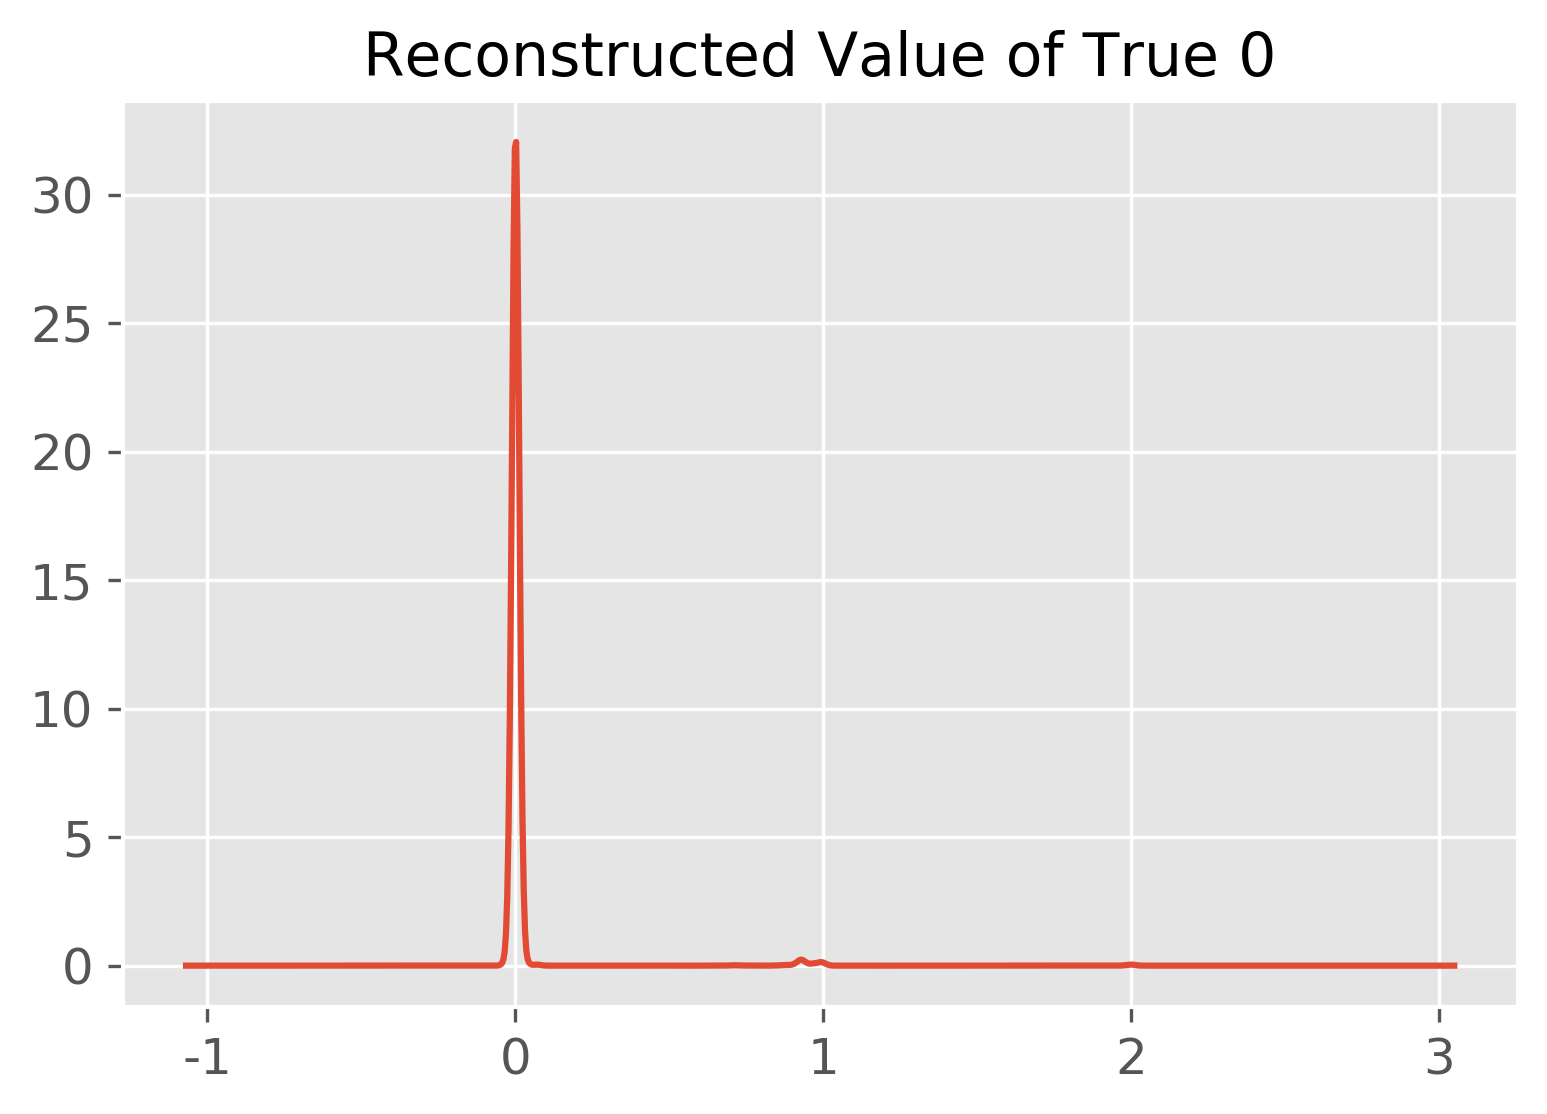

In [1609]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==0]['pred'].plot.kde()
plt.title('Reconstructed Value of True 0')
plt.ylabel("")

Text(0.5, 0, 'Reconstructed Value')

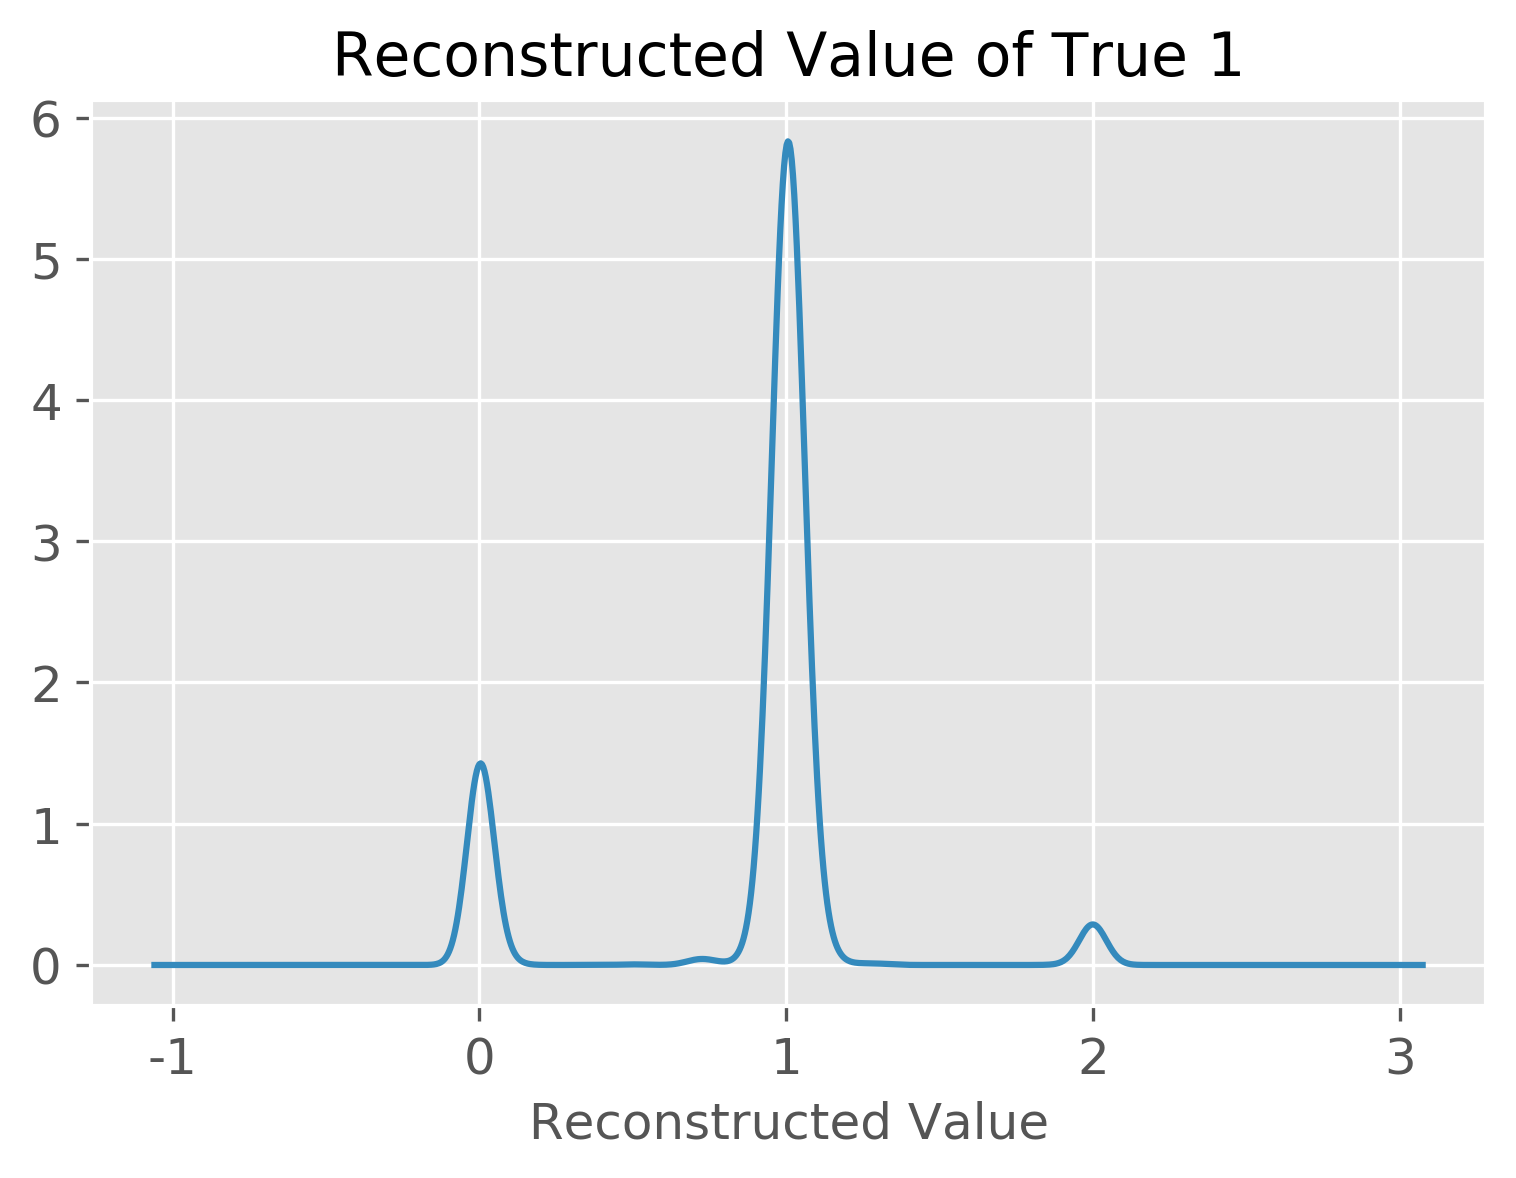

In [1601]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==1]['pred'].plot.kde(c='#348abd')
plt.title('Reconstructed Value of True 1')
plt.ylabel("")
plt.xlabel('Reconstructed Value')

Text(0, 0.5, '')

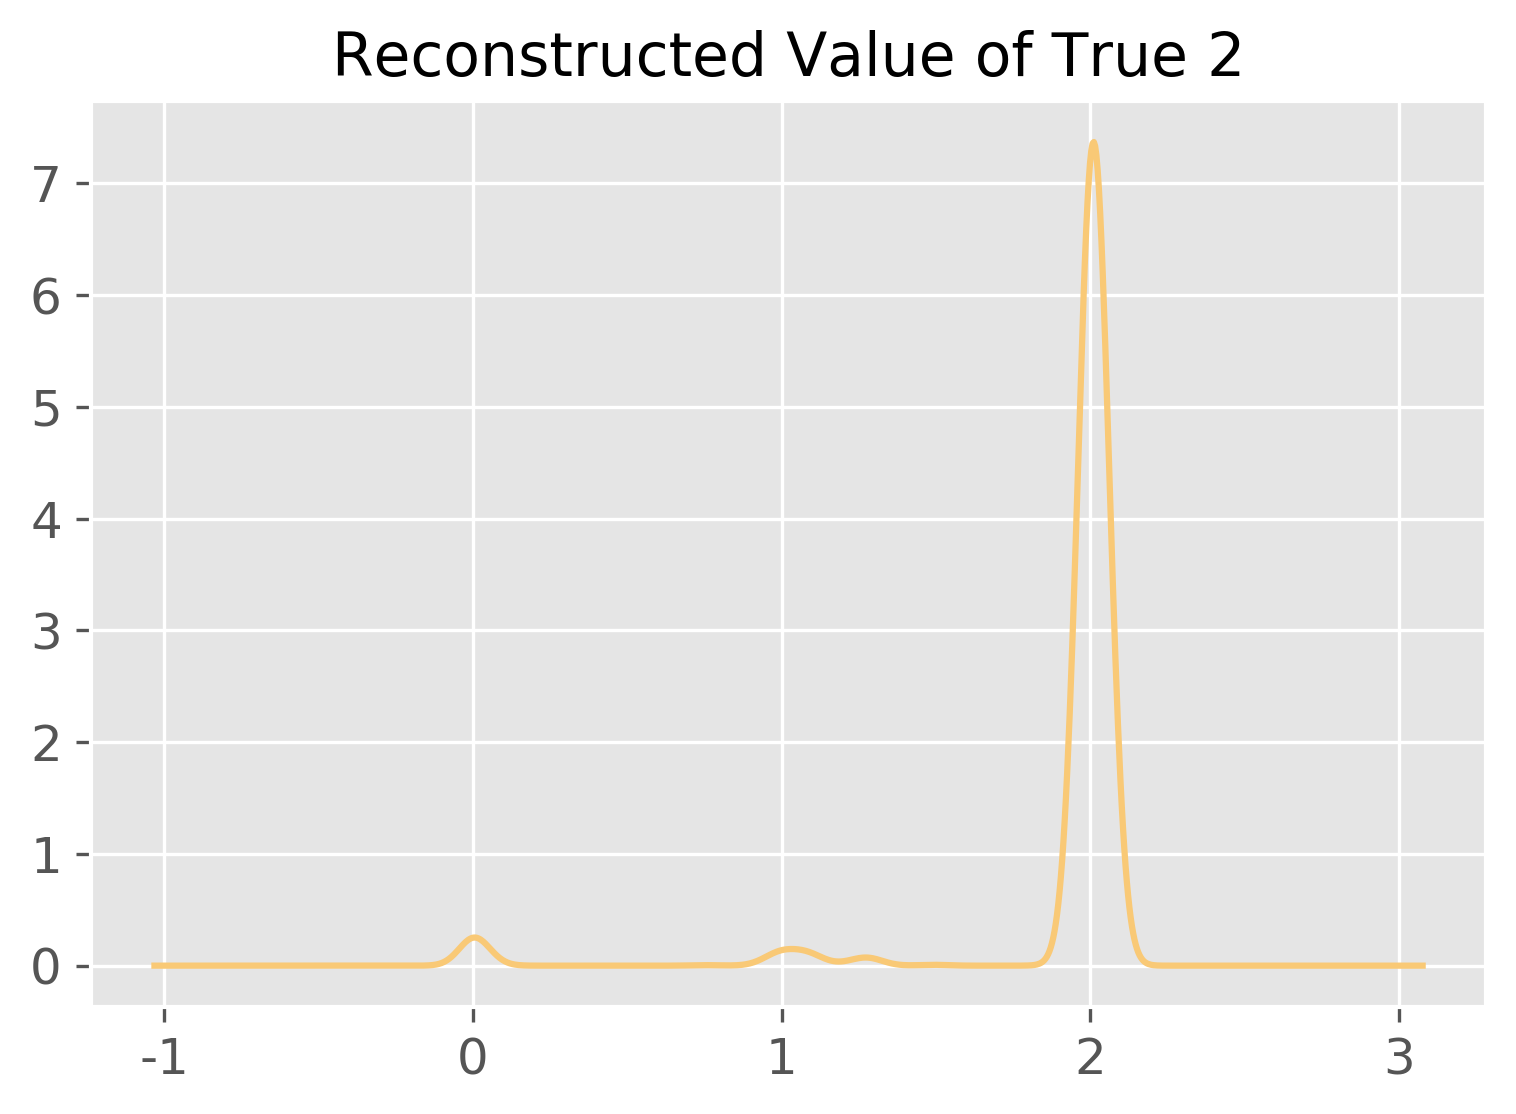

In [1608]:
pred_all = reduce(lambda x, y: pd.concat([x, y]), pred_list)
plt.figure(dpi=300)
pred_all[pred_all['x_test']==2]['pred'].plot.kde(c='#f9c976')
plt.title('Reconstructed Value of True 2')
plt.ylabel("")

# Model build

In [1268]:
def get_min_coef(fold_test_result, model_num):
    min_auc = 100
    min_coef = 0
    for fold_i in fold_test_result:
        if min_auc > fold_i[model_num][3]:
            min_auc = fold_i[model_num][3]
            min_coef = fold_i[model_num][4]
    return min_coef

In [1269]:
from sklearn.preprocessing import StandardScaler
def create_y_merge_df(train_type, fold_num, ex_num):
    y_value = 'y'
    label_df = pd.read_csv(get_bed_path('label', train_type, fold_num, y=y_value), delim_whitespace=True)
    score_df = pd.read_csv(get_bed_path('score', train_type, fold_num, y=y_value, ex=ex_num), delim_whitespace=True)
    ml_input = label_df.merge(score_df, how='inner', on='IID')[['IID', 'y', 'sex', 'age', 'bmi', 'sbp', 'dbp', 'SCORESUM']].rename(columns={'SCORESUM': f'{y_value}_input'})
    return ml_input

def analyze_model_dict(model_dict, X_train, X_test, y_train, y_test):
    train_result_list = []
    test_result_list = []
    model_list = []
    
    for model_name, model in model_dict.items():

        # Train
        fitted_model = model.fit(X_train, y_train)
        model_list.append(fitted_model)
        
        # For train data
        train_pred = fitted_model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_score = precision_recall_fscore_support(y_train, train_pred)
        train_auc = roc_auc_score(y_train, fitted_model.decision_function(X_train))
        train_result_list.append([model_name, train_acc, train_score, train_auc, fitted_model.C_])
       
        # For test data
        test_pred = fitted_model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_score = precision_recall_fscore_support(y_test, test_pred)
        test_auc = roc_auc_score(y_test, fitted_model.decision_function(X_test))
        test_result_list.append([model_name, test_acc, test_score, test_auc, fitted_model.C_])
        
    return train_result_list, test_result_list, model_list

In [1479]:
# Create merge df
def build_model(with_cvar, cs_value, code_input=None, ex_num=100):
    fold_train_result = []
    fold_test_result = []
    fold_model_result = []
    for fold_num in range(1, 6):
        if code_input:
            code_train_list = code_input[0]
            code_test_list = code_input[1]
            train_data = create_y_merge_df('train', fold_num, ex_num)
            train_data = train_data.drop('y_input', axis=1)\
                .merge(code_train_list[fold_num-1].drop('y', axis=1).rename(columns={'code': 'y_input'}), on='IID')
            test_data = create_y_merge_df('test', fold_num, ex_num)
            test_data = test_data.drop('y_input', axis=1)\
                .merge(code_test_list[fold_num-1].drop('y', axis=1).rename(columns={'code': 'y_input'}), on='IID')
        else:
            train_data = create_y_merge_df('train', fold_num, ex_num)
            test_data = create_y_merge_df('test', fold_num, ex_num)

        #for col in ['y_input']:
        #    scaler = normalize(train_data, col)
        #    normalize(test_data, col, scaler)

        # Split
        if with_cvar:
            X_train = train_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
            X_test = test_data[['sex', 'age', 'bmi', 'sbp', 'dbp', 'y_input']]
        else:
            X_train = train_data[['y_input']]
            X_test = test_data[['y_input']]
    
        y_train = train_data[['y']]
        y_test = test_data[['y']]

        model_dict = {
            'Logistic Ridge': LogisticRegressionCV(penalty='l2', Cs=cs_value[0], scoring='roc_auc', solver='lbfgs',  random_state=random_seed),
            'Logistic Lasso': LogisticRegressionCV(penalty='l1', Cs=cs_value[1], scoring='roc_auc', solver='saga', random_state=random_seed),
        }

        train_result, test_result, model_result = analyze_model_dict(model_dict, X_train, X_test, y_train, y_test)
        fold_train_result.append(train_result)
        fold_test_result.append(test_result)
        fold_model_result.append(model_result)

    return fold_train_result, fold_test_result, fold_model_result

In [1576]:
%%time
#  SNP 갯수에 때한 PRS 모델 비교
l2_list = []
l1_list = []
with_cvar = True
for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], ex_num=ex_num)
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], ex_num=ex_num)
    print("*****", ex_num, "*****")
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

***** 10 *****
test acu ridge 0.6611506522579822 0.03852349541669048
test acu lasso 0.6639826417491653 0.039151615668299694
***** 50 *****
test acu ridge 0.6373454432041396 0.04570830940432067
test acu lasso 0.6501666846705437 0.049847798896285746
***** 100 *****
test acu ridge 0.669845042486549 0.031136104744818142
test acu lasso 0.6690116226412058 0.03152994996681446
***** 500 *****
test acu ridge 0.647620866881866 0.02534166795967367
test acu lasso 0.6358724135328078 0.05105851454250878
***** 1000 *****
test acu ridge 0.6324463142192978 0.020523972178633255
test acu lasso 0.6182314331051924 0.05680561059788626
***** 5000 *****
test acu ridge 0.603391509336916 0.019341741456573927
test acu lasso 0.5508454788986292 0.03879151538041342
***** 10000 *****
test acu ridge 0.5916564337772799 0.01842869920538683
test acu lasso 0.5360059240801638 0.04307206112560413
***** 50000 *****
test acu ridge 0.507601230574636 0.023077597067437984
test acu lasso 0.5040982923180249 0.027251209769975613
C

Text(0, 0.5, 'AUC')

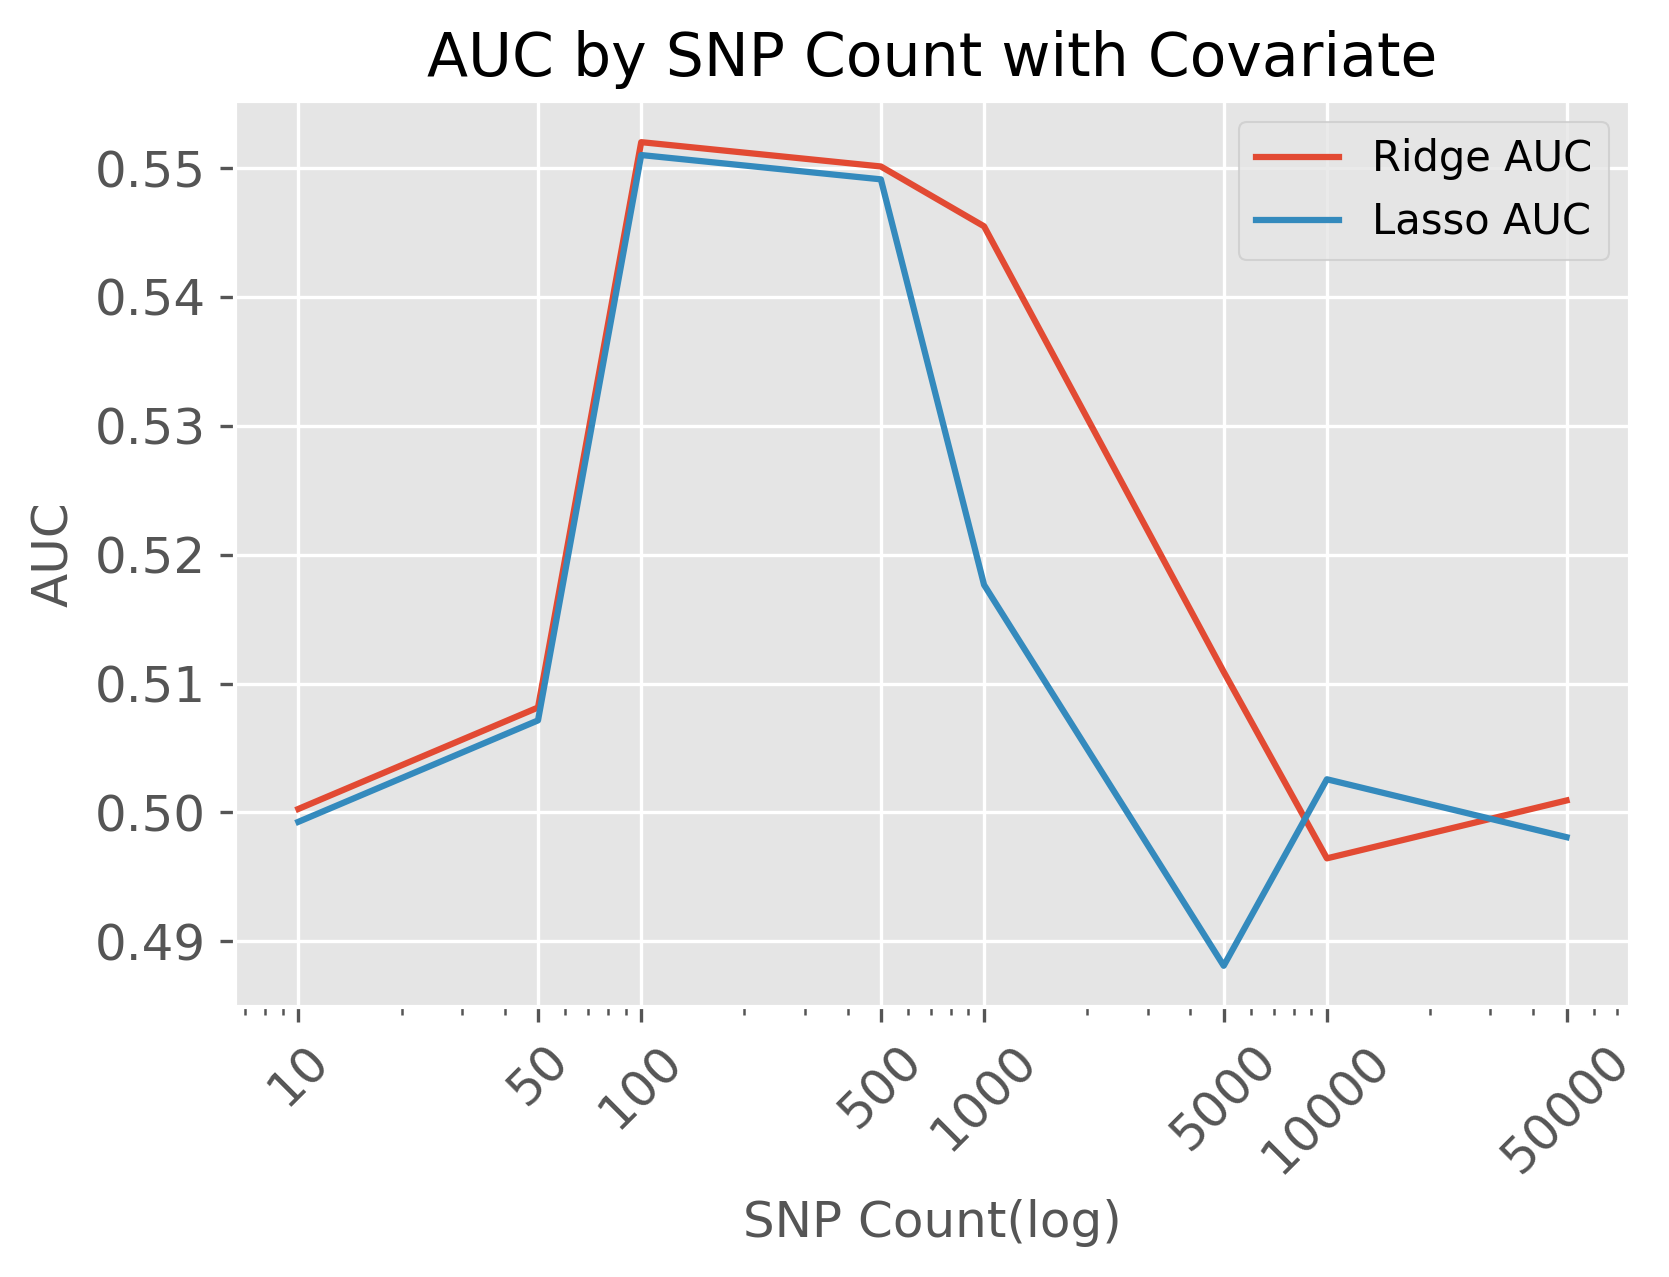

In [1605]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count with Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [1578]:
%%time
#  SNP 갯수에 때한 PRS 모델 비교
l2_list = []
l1_list = []
with_cvar = False
for ex_num in [10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], ex_num=ex_num)
    fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                         [get_min_coef(fold_test_result, 1)[0]]], ex_num=ex_num)
    print("*****", ex_num, "*****")
    print('test acu ridge',
          np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
    l2_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
    print('test acu lasso',
          np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
          np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
    l1_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

***** 10 *****
test acu ridge 0.5002657980569472 0.018848346685711736
test acu lasso 0.5002657980569472 0.018848346685711736
***** 50 *****
test acu ridge 0.5081381540650123 0.03604861592170805
test acu lasso 0.5081381540650123 0.03604861592170805
***** 100 *****
test acu ridge 0.5520146512339215 0.02887812341816267
test acu lasso 0.5520146512339215 0.02887812341816267
***** 500 *****
test acu ridge 0.5501285508251528 0.029599873426447154
test acu lasso 0.5501285508251528 0.029599873426447154
***** 1000 *****
test acu ridge 0.5454834683425382 0.03100631877909448
test acu lasso 0.5186607495909551 0.05178720036264935
***** 5000 *****
test acu ridge 0.5109064528352576 0.030023835855102272
test acu lasso 0.4890935471647424 0.030023835855102262
***** 10000 *****
test acu ridge 0.4964316603719154 0.03634830024700792
test acu lasso 0.5035683396280846 0.036348300247007935
***** 50000 *****
test acu ridge 0.5009247453302526 0.026483888727018193
test acu lasso 0.49907525466974745 0.0264838887270

Text(0, 0.5, 'AUC')

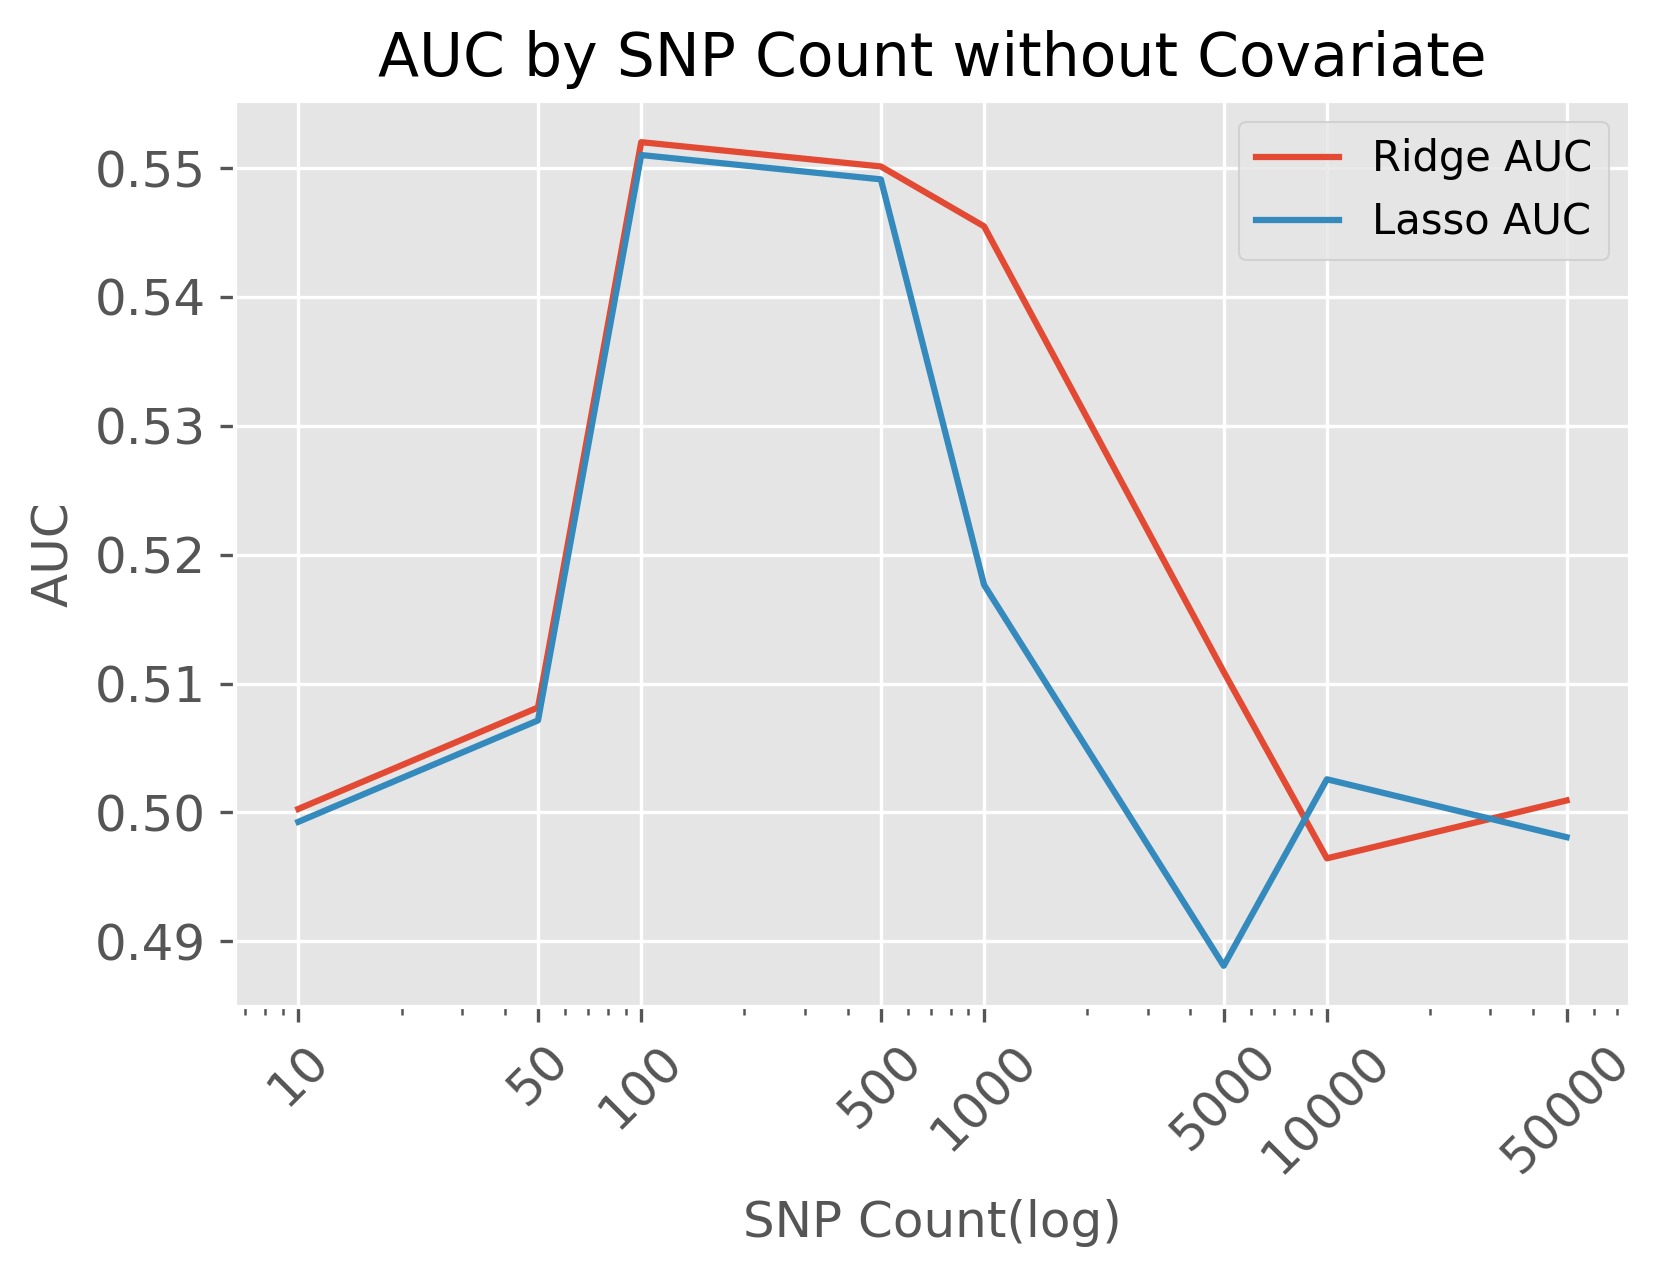

In [1579]:
ex_num = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.figure(dpi=300)
plt.plot(ex_num, l2_list)
plt.plot(ex_num, [auc -1e-3 for auc in l1_list])
plt.legend(['Ridge AUC', 'Lasso AUC'])
plt.xscale('log')
plt.xticks(ex_num, ex_num, rotation=45)
plt.title('AUC by SNP Count without Covariate')
plt.xlabel('SNP Count(log)')
plt.ylabel('AUC')

In [1556]:
0.6698-0.5520

0.1177999999999999

In [1645]:
%%time
# 모델 간의 비교
ridge_wc_list = []
lasso_wc_list = []
with_cvar = True
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], ex_num=10)
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                     [get_min_coef(fold_test_result, 1)[0]]], ex_num=10)
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.6611506522579822 0.03852349541669048
test acu lasso 0.6639826417491653 0.039151615668299694
CPU times: user 55.2 s, sys: 1min 27s, total: 2min 22s
Wall time: 7.23 s


In [1646]:
%%time
with_cvar = True
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                     [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.6909131907284116 0.035780369191903034
test acu lasso 0.6906749072258511 0.03594941489152496
CPU times: user 58.6 s, sys: 1min 32s, total: 2min 30s
Wall time: 8.09 s


In [1652]:
0.6909-0.6639

0.026999999999999913

Text(0, 0.5, 'AUC')

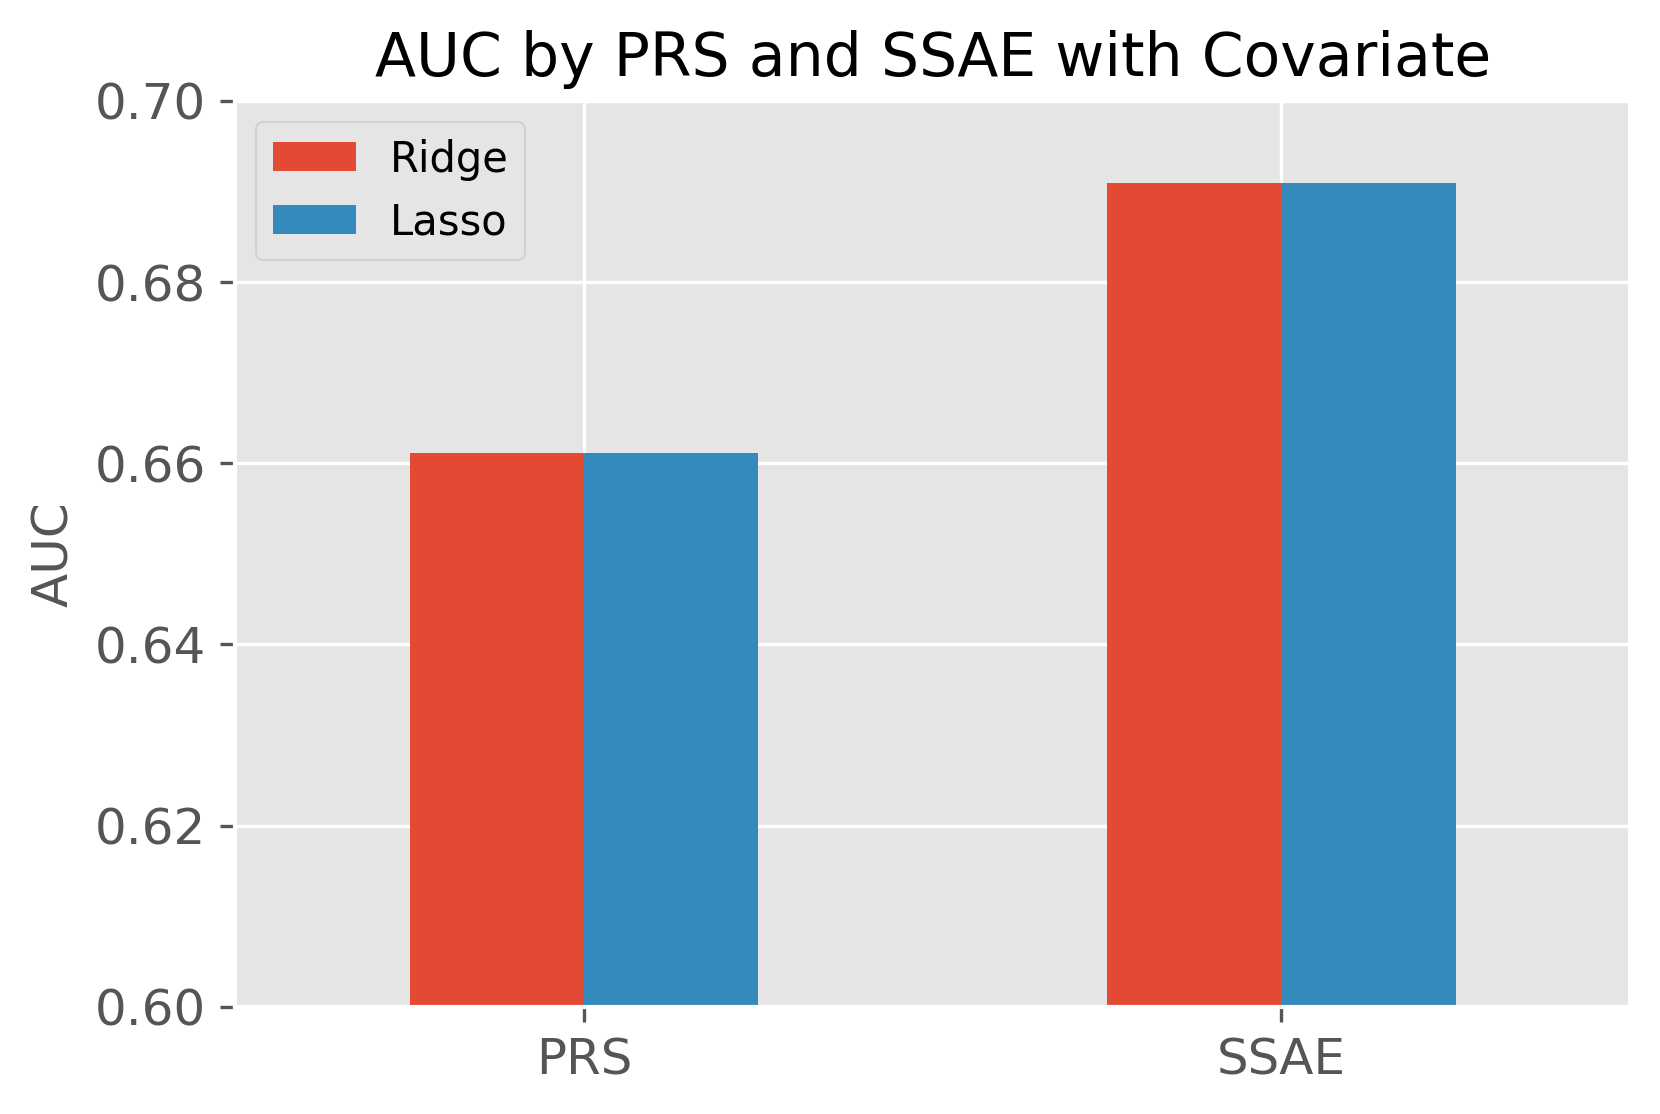

In [1647]:
pd.DataFrame({'Ridge': ridge_wc_list, 'Lasso': ridge_wc_list },
             index=['PRS', 'SSAE']).plot.bar(rot=0)
plt.ylim(0.6, 0.7)
plt.title('AUC by PRS and SSAE with Covariate')
plt.ylabel('AUC')

In [1658]:
%%time
# 모델 간의 비교
ridge_wc_list = []
lasso_wc_list = []
with_cvar = False
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5])
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                     [get_min_coef(fold_test_result, 1)[0]]])
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.5520146512339215 0.02887812341816267
test acu lasso 0.5520146512339215 0.02887812341816267
CPU times: user 5.63 s, sys: 0 ns, total: 5.63 s
Wall time: 5.63 s


In [1659]:
%%time
with_cvar = False
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [5, 5], [code_train_list, code_test_list])
fold_train_result, fold_test_result, fold_model_result = build_model(with_cvar, [[get_min_coef(fold_test_result, 0)[0]],
                                                                     [get_min_coef(fold_test_result, 1)[0]]], [code_train_list, code_test_list])
print('test acu ridge',
      np.mean([fold_i[0][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[0][3] for fold_i in fold_test_result]))  # test acu std
print('test acu lasso',
      np.mean([fold_i[1][3] for fold_i in fold_test_result]), # test acu mean
      np.std([fold_i[1][3] for fold_i in fold_test_result]))  # test acu std
ridge_wc_list.append(np.mean([fold_i[0][3] for fold_i in fold_test_result]))
lasso_wc_list.append(np.mean([fold_i[1][3] for fold_i in fold_test_result]))

test acu ridge 0.5698757914814103 0.03857919659411045
test acu lasso 0.5698757914814103 0.03857919659411045
CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.09 s


In [1662]:
0.570 - 0.552

0.017999999999999905

Text(0, 0.5, 'AUC')

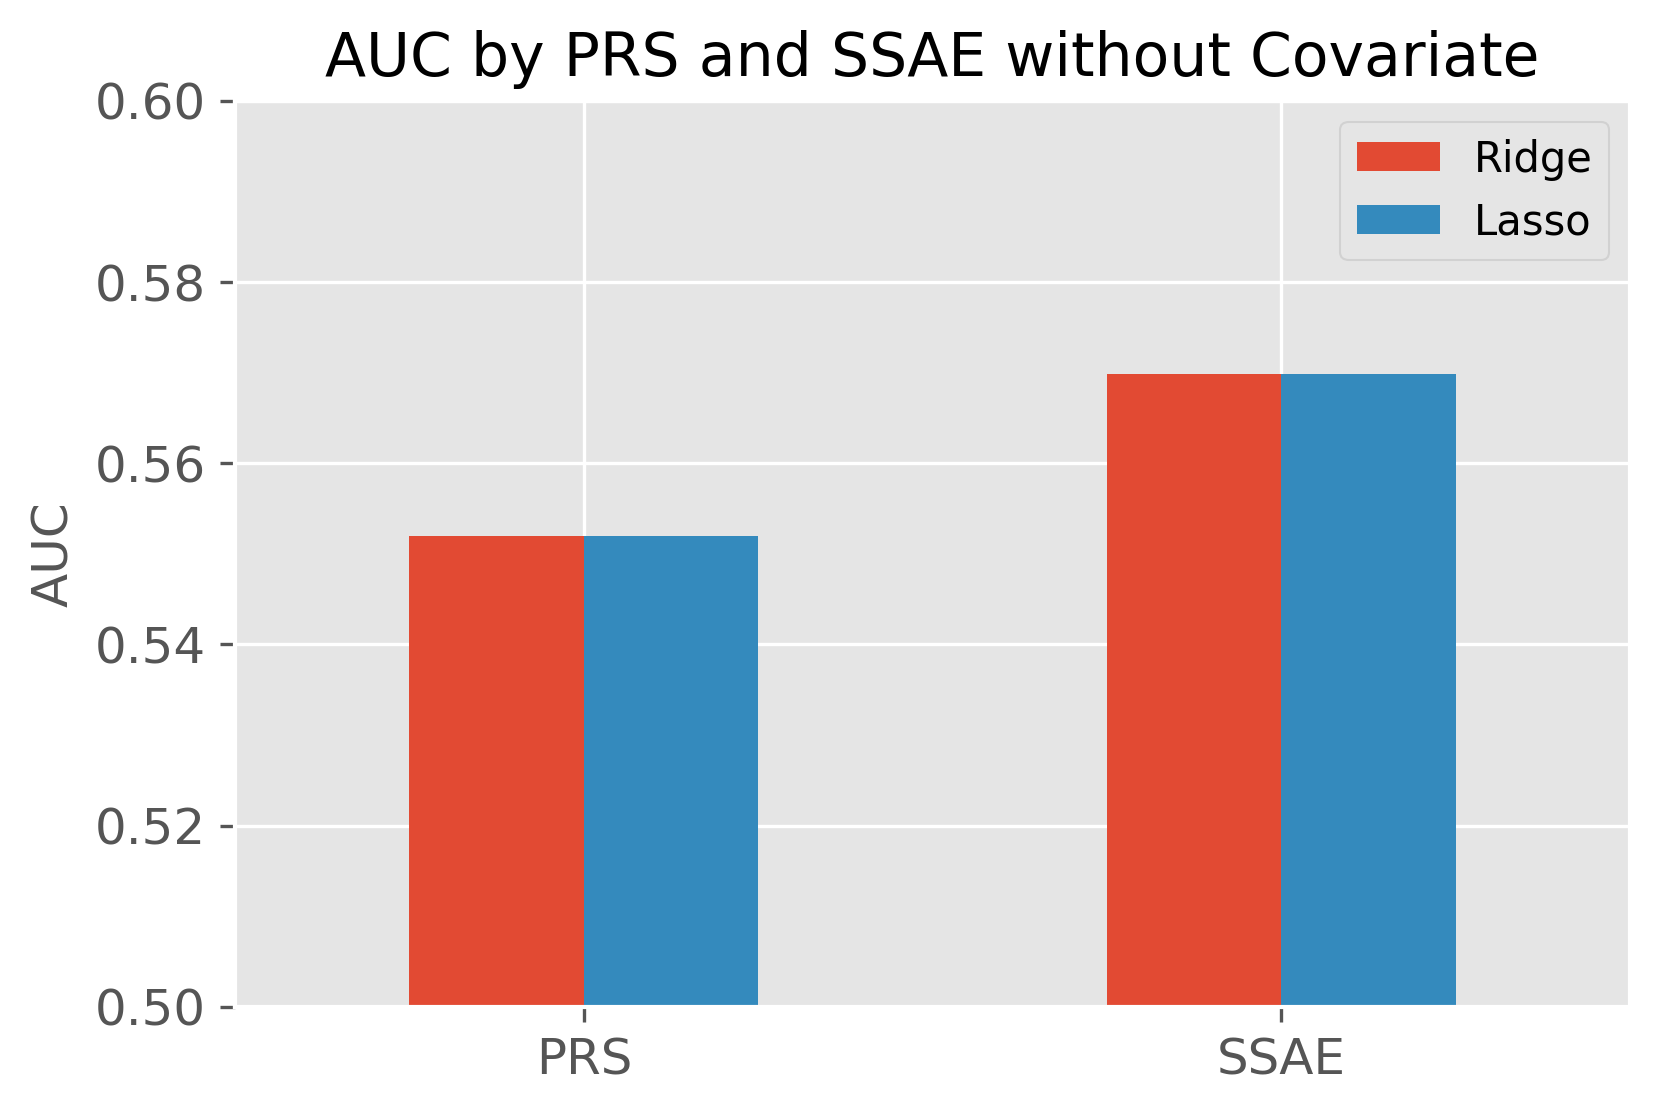

In [1660]:
pd.DataFrame({'Ridge': ridge_wc_list, 'Lasso': ridge_wc_list },
             index=['PRS', 'SSAE']).plot.bar(rot=0)
plt.ylim(0.5, 0.6)
plt.title('AUC by PRS and SSAE without Covariate')
plt.ylabel('AUC')

In [1448]:
test_data_list = []
for fold_num in range(1, 6):
    test_data = create_y_merge_df('test', fold_num, ex_num)
    test_data_list.append(test_data[['y', 'y_input']])
test_data_all = reduce(lambda x, y: pd.concat([x, y]), test_data_list)

In [1423]:
code_test_all = reduce(lambda x, y: pd.concat([x, y]), code_test_list)

Text(0.5, 0, 'Y')

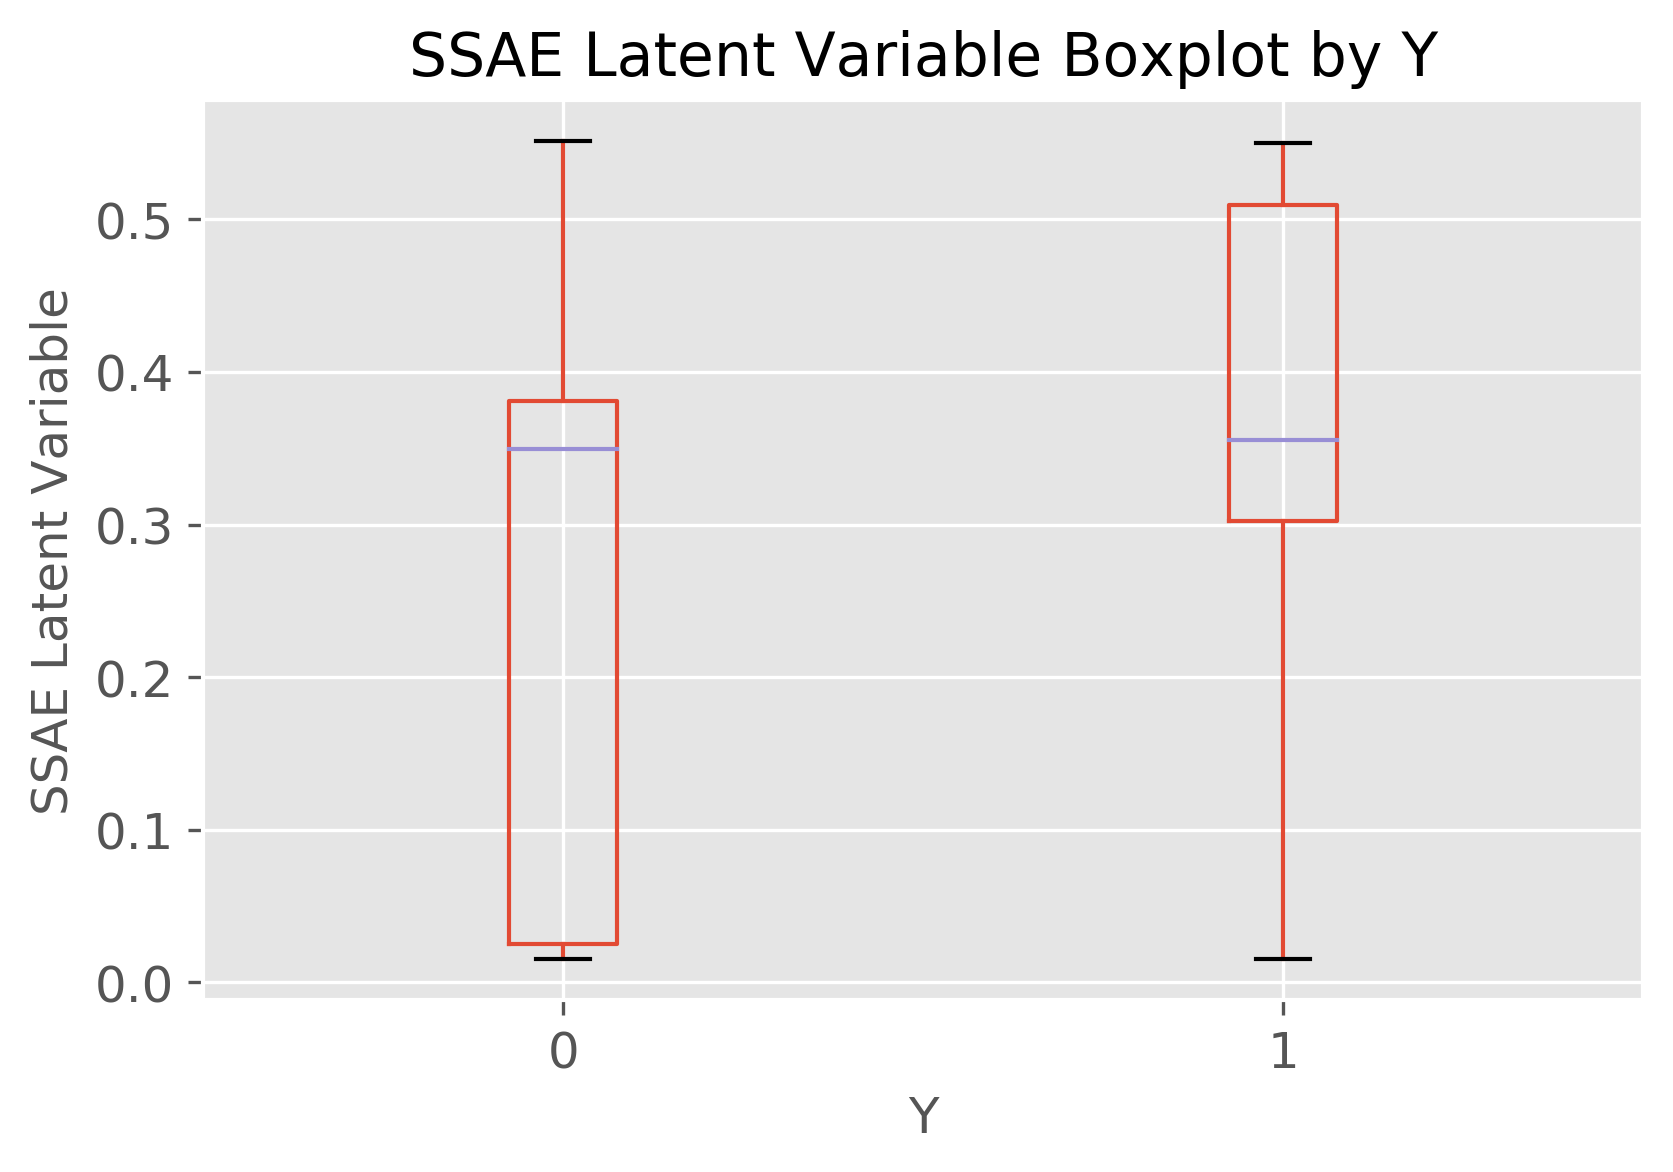

In [1696]:
code_test_all[['code', 'y']].boxplot(by='y')
plt.title('SSAE Latent Variable Boxplot by Y')
plt.suptitle('')
plt.ylabel('SSAE Latent Variable')
plt.xlabel('Y')

Text(0.5, 0, 'Y')

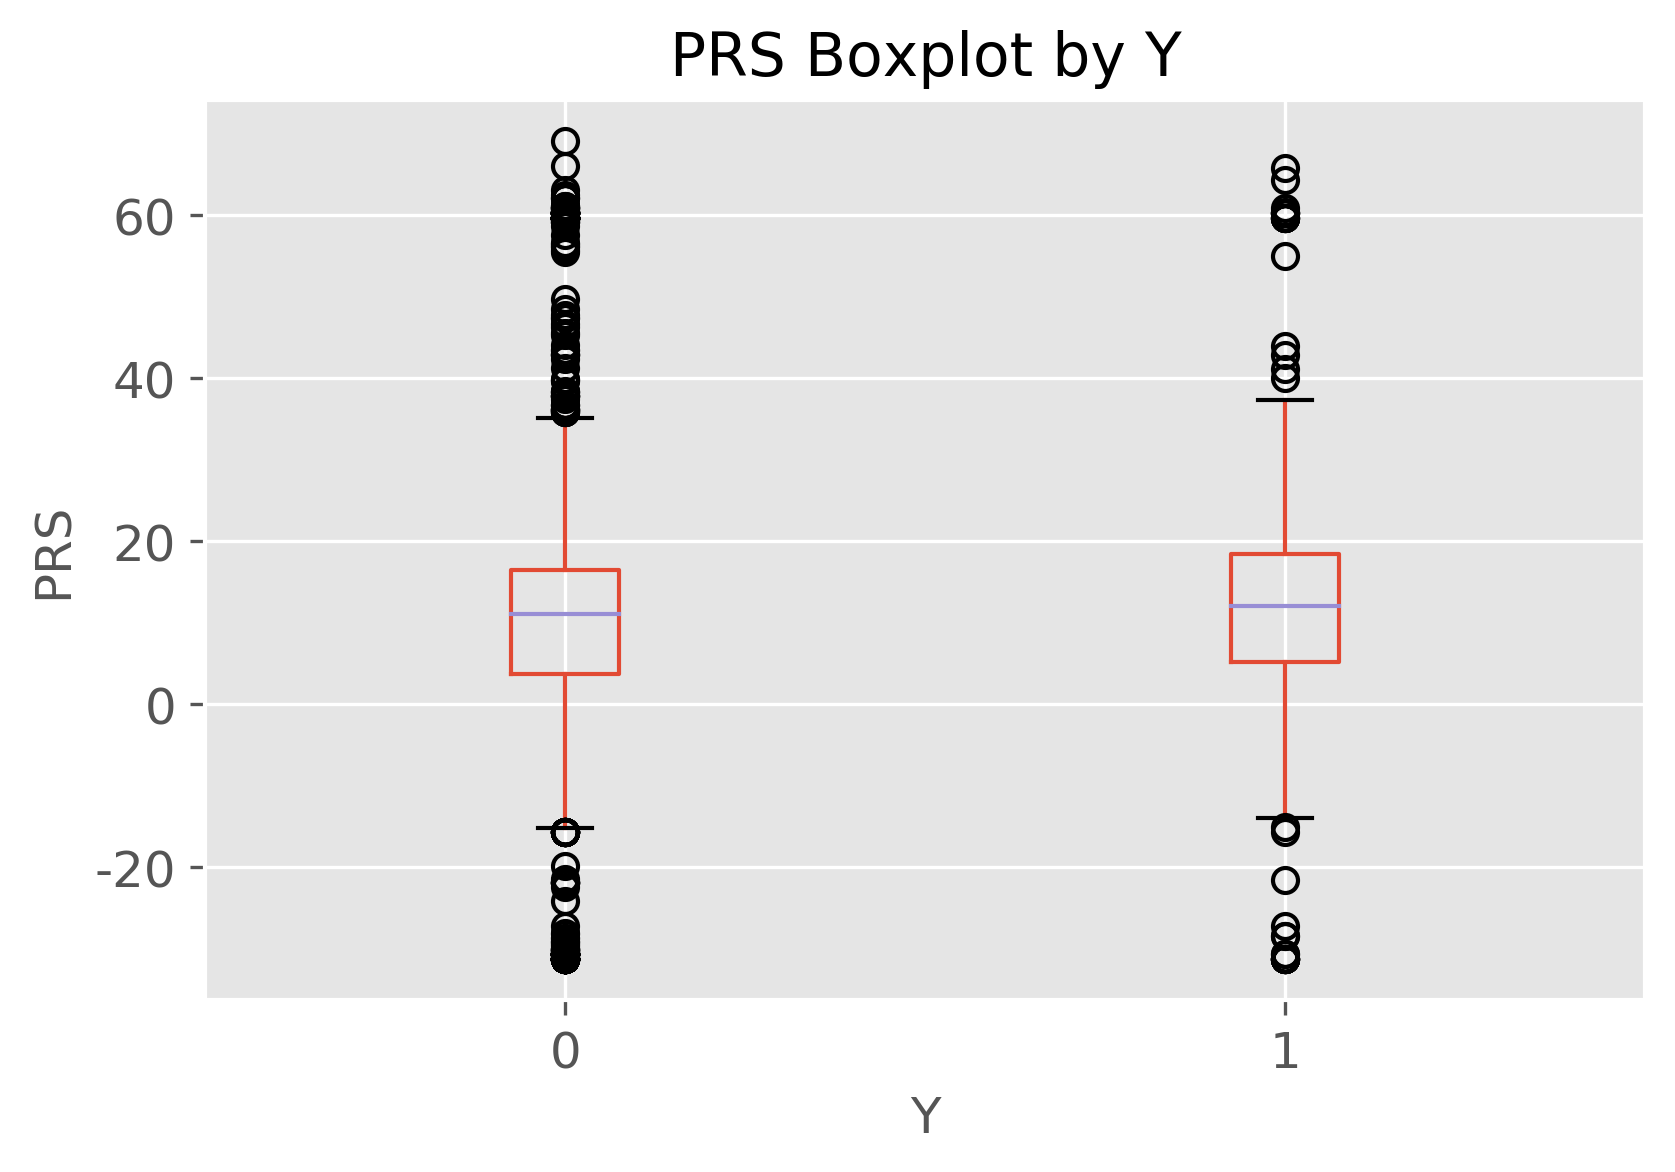

In [1697]:
test_data_all[['y_input', 'y']].boxplot(by='y')
plt.title('PRS Boxplot by Y')
plt.suptitle('')
plt.ylabel('PRS')
plt.xlabel('Y')

In [1679]:
pd.DataFrame({'Y=0': code_test_all[code_test_all['y']==0][['code']],
              'Y=1': code_test_all[code_test_all['y']==1][['code']]}).plot.bar(rot=0)
#plt.ylim(0.5, 0.6)
#plt.title('AUC by PRS and SSAE without Covariate')
#plt.ylabel('AUC')

ValueError: If using all scalar values, you must pass an index

(0, 0.6)

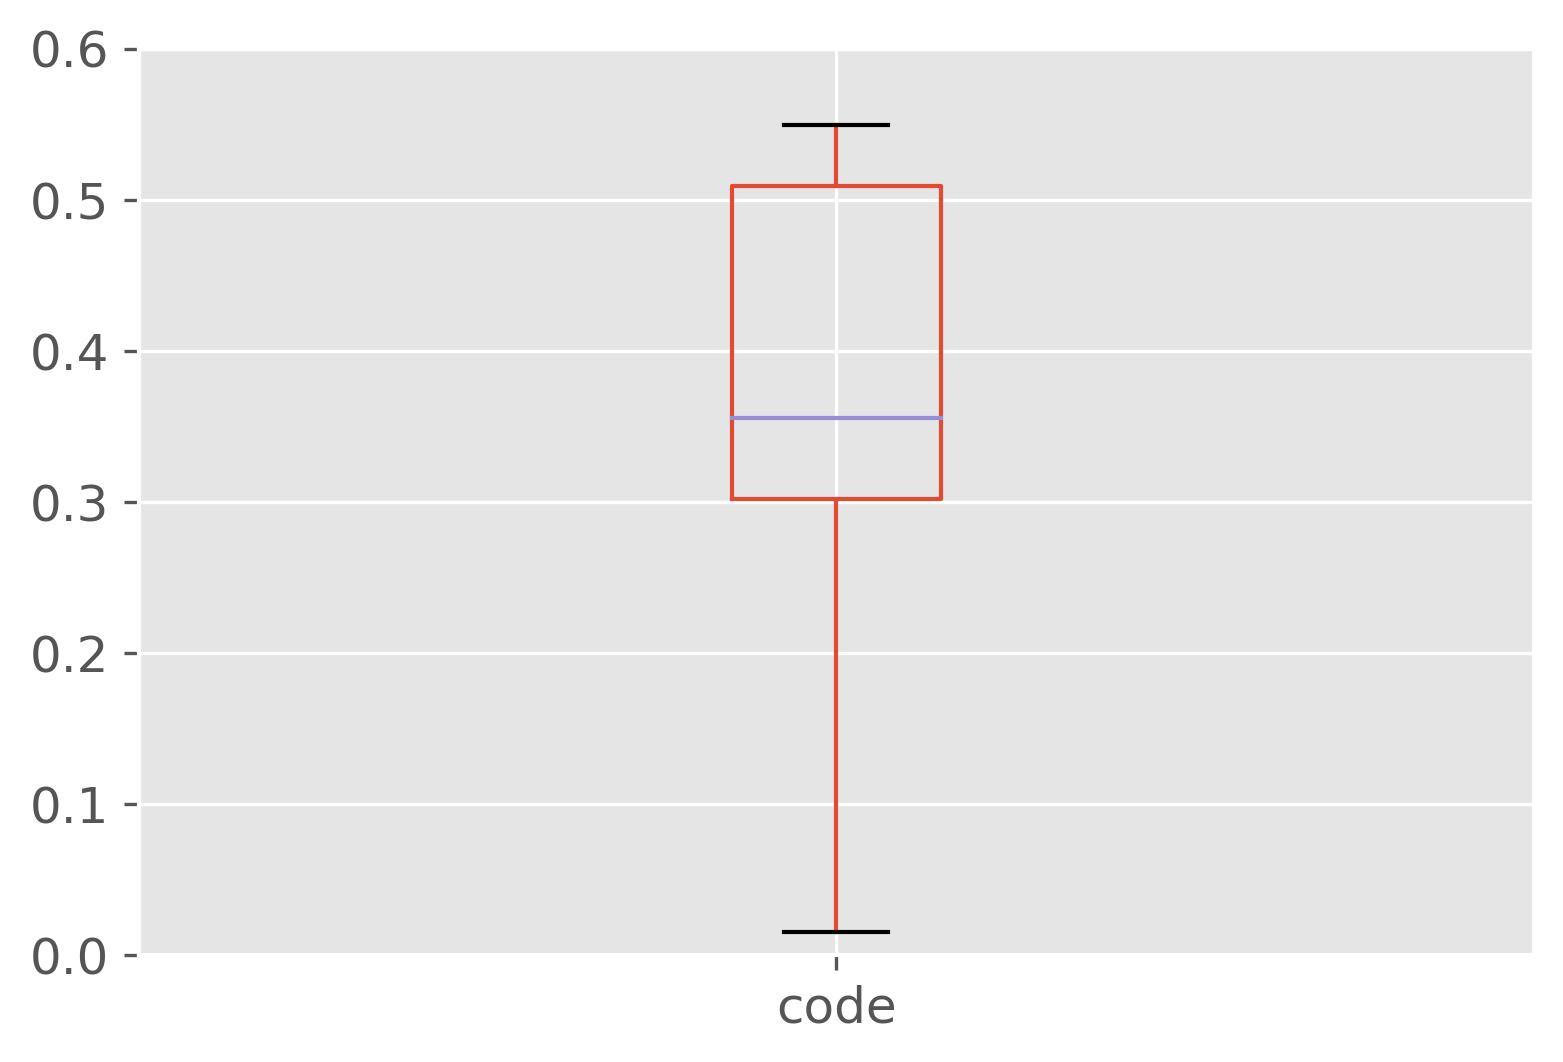

In [1663]:
code_test_all[code_test_all['y']==1][['code']].boxplot()
plt.ylim(0, 0.6)

(0, 0.6)

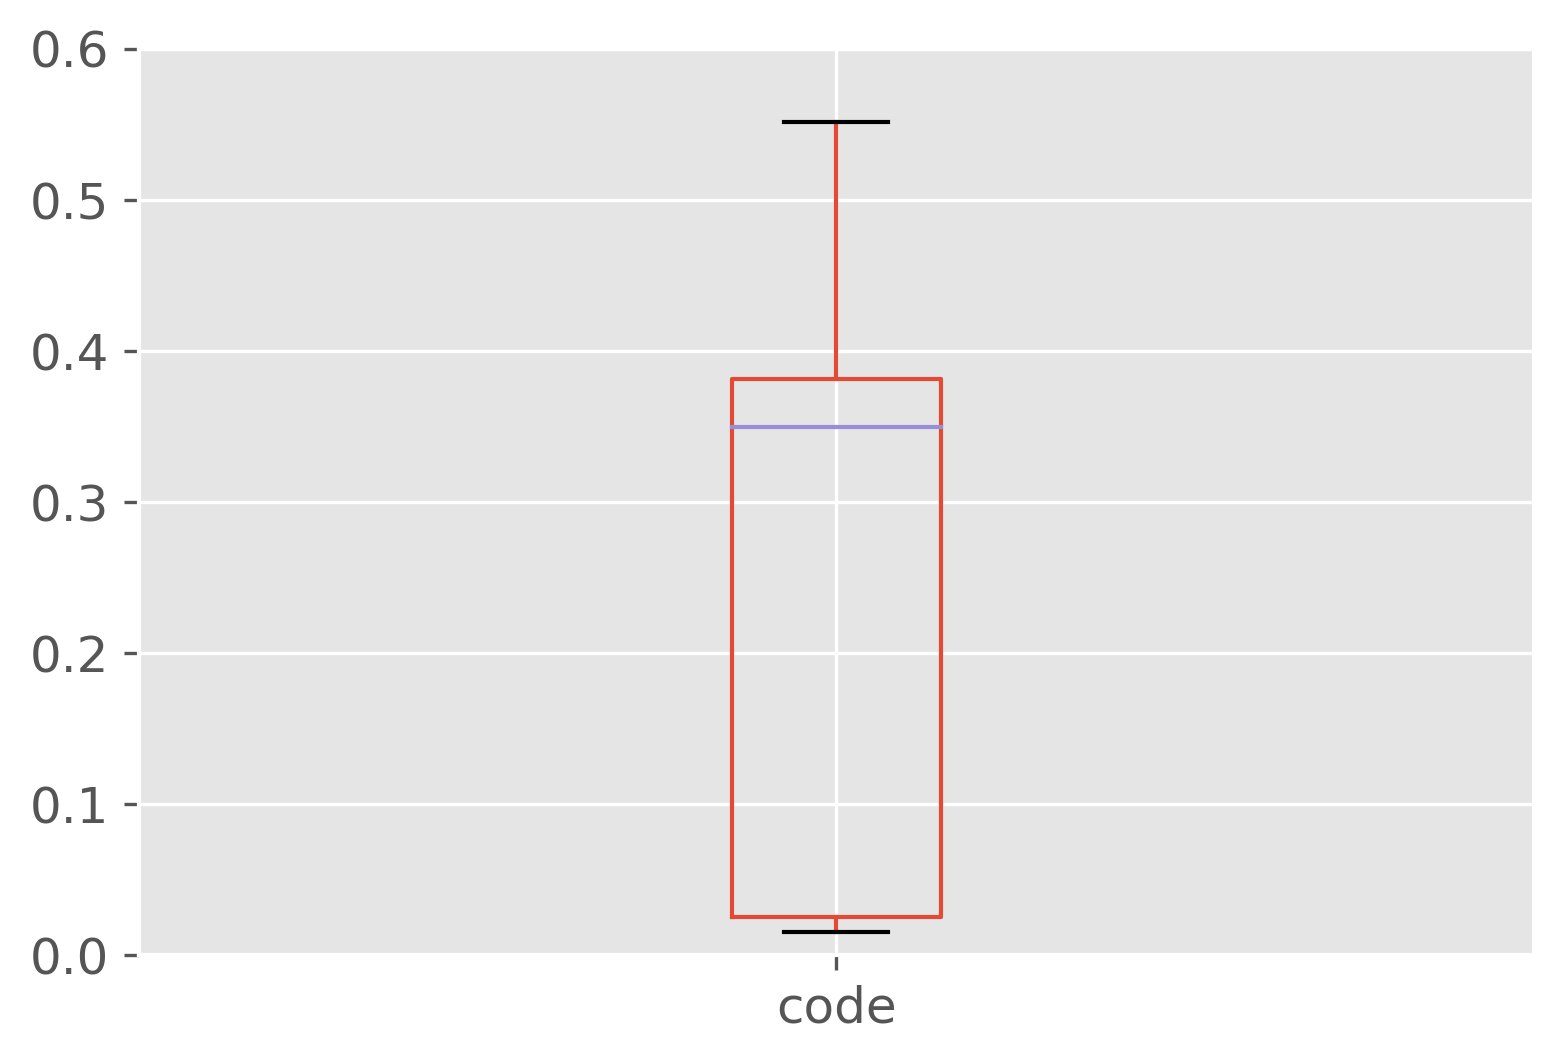

In [1664]:
code_test_all[code_test_all['y']==0][['code']].boxplot()
plt.ylim(0, 0.6)

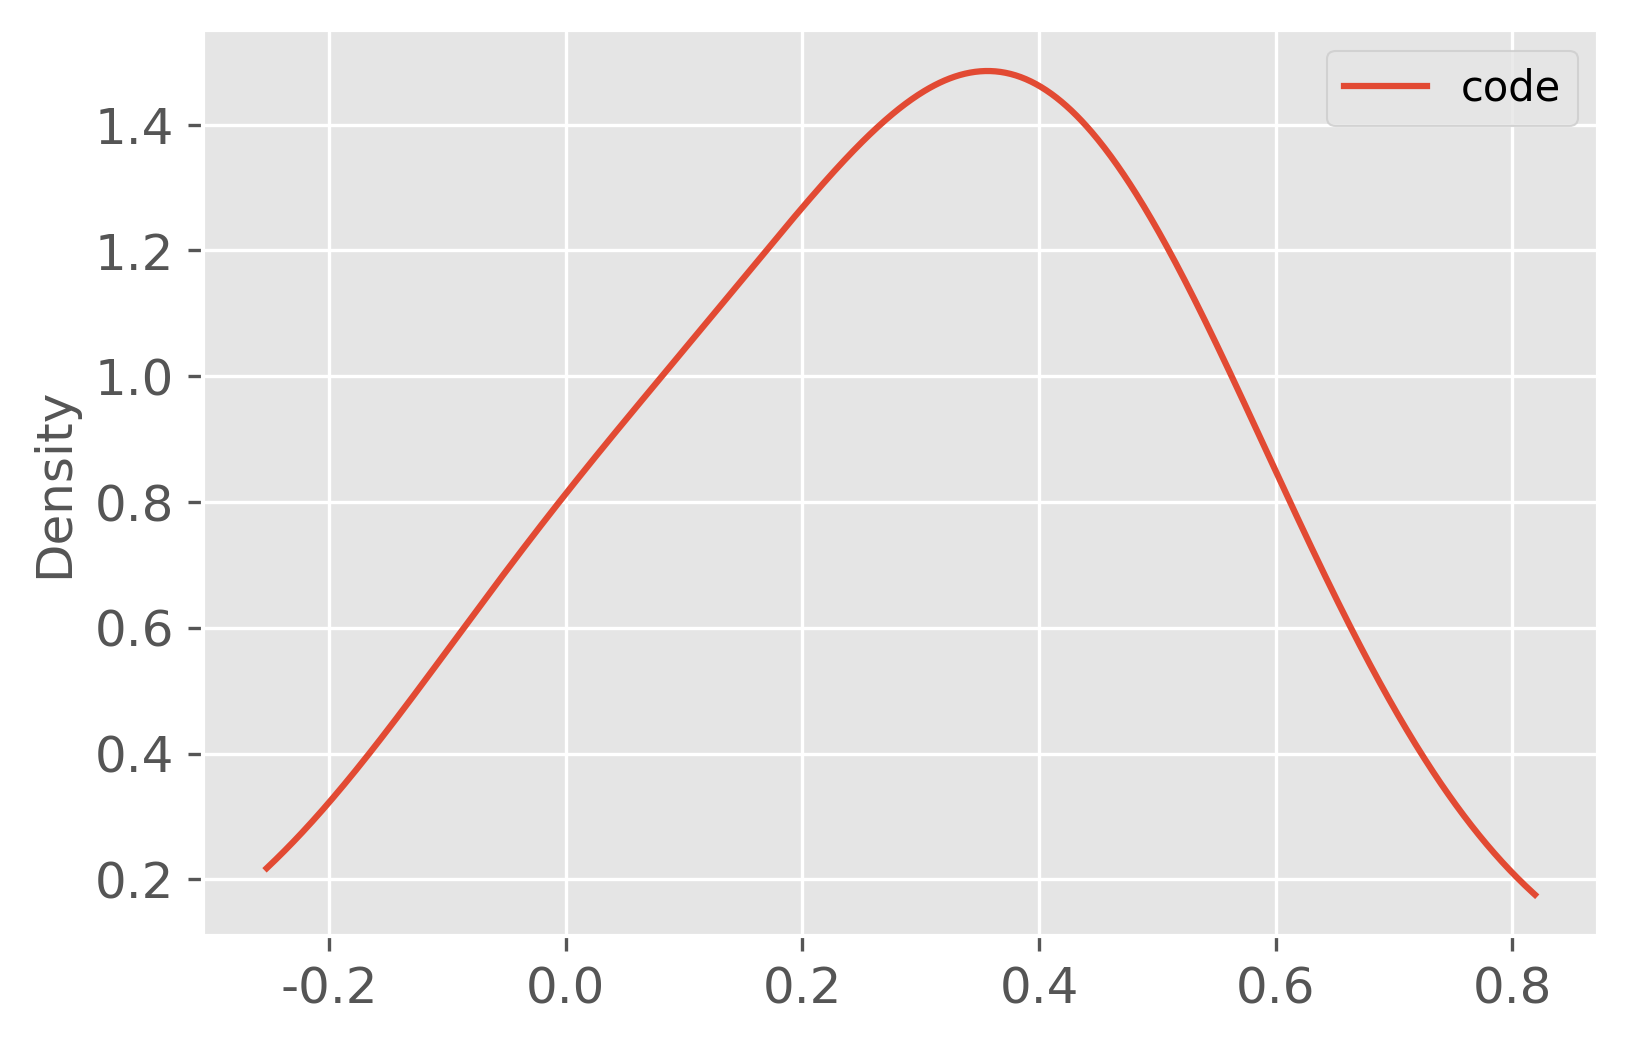

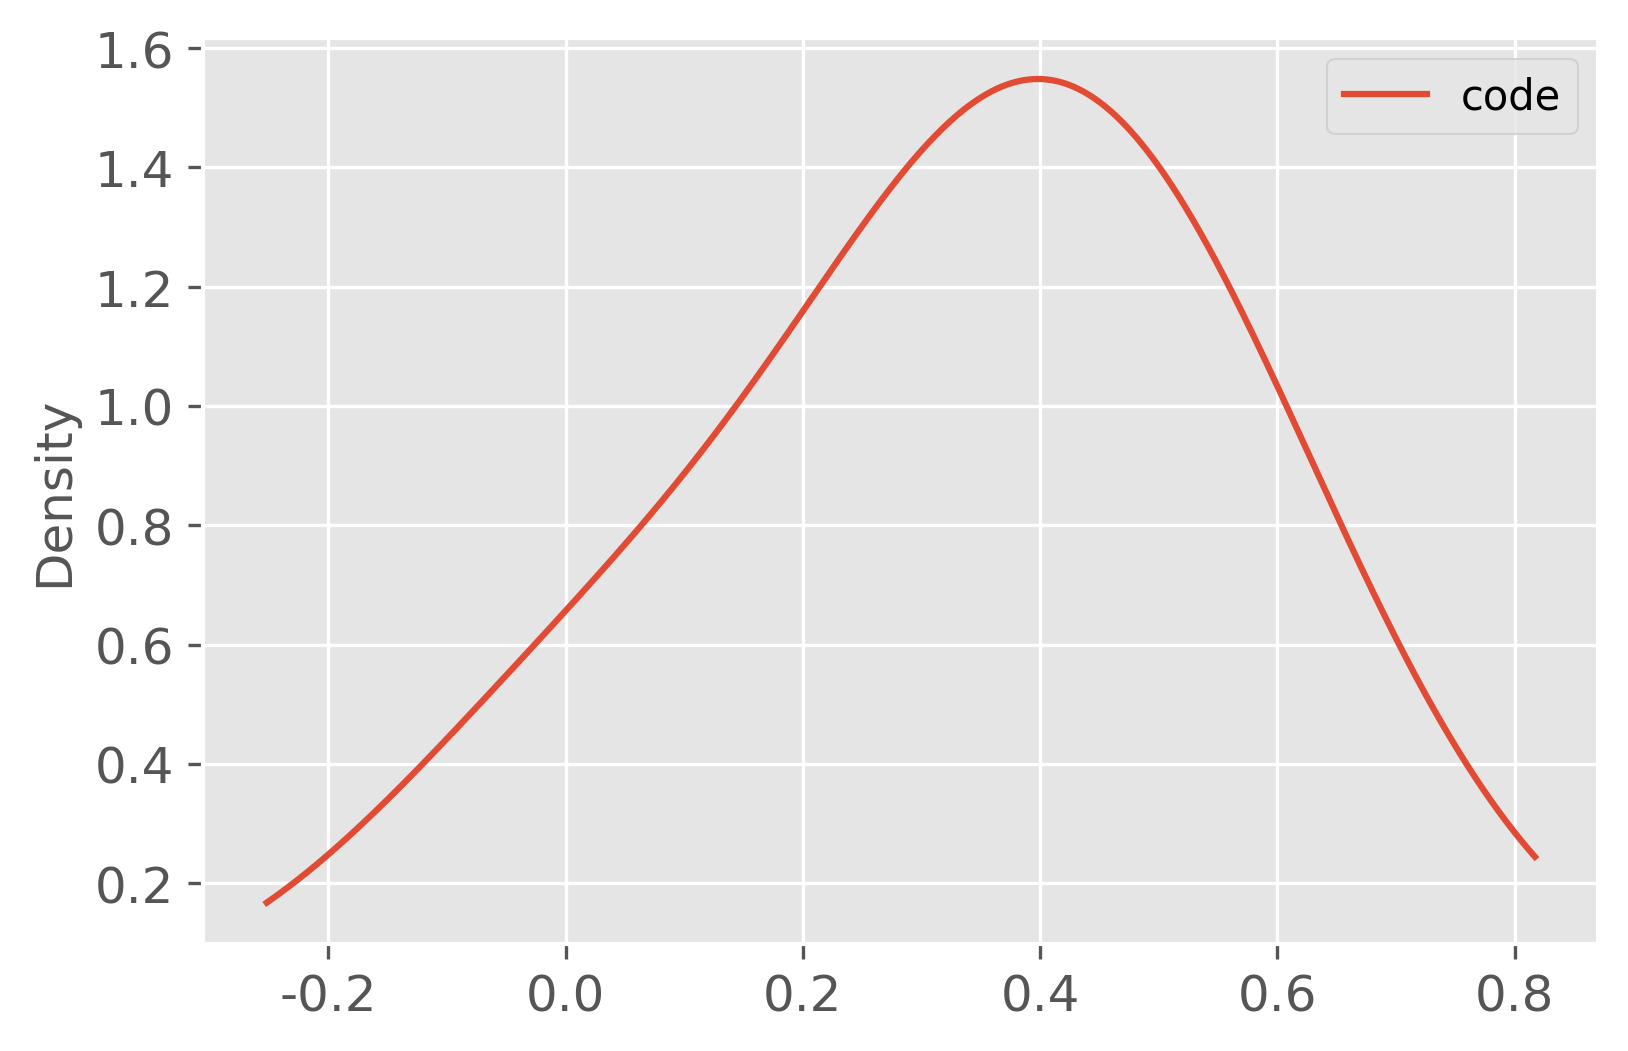

In [1678]:
code_test_all[code_test_all['y']==0][['code']].plot.kde(bw_method=1)
code_test_all[code_test_all['y']==1][['code']].plot.kde(bw_method=1)

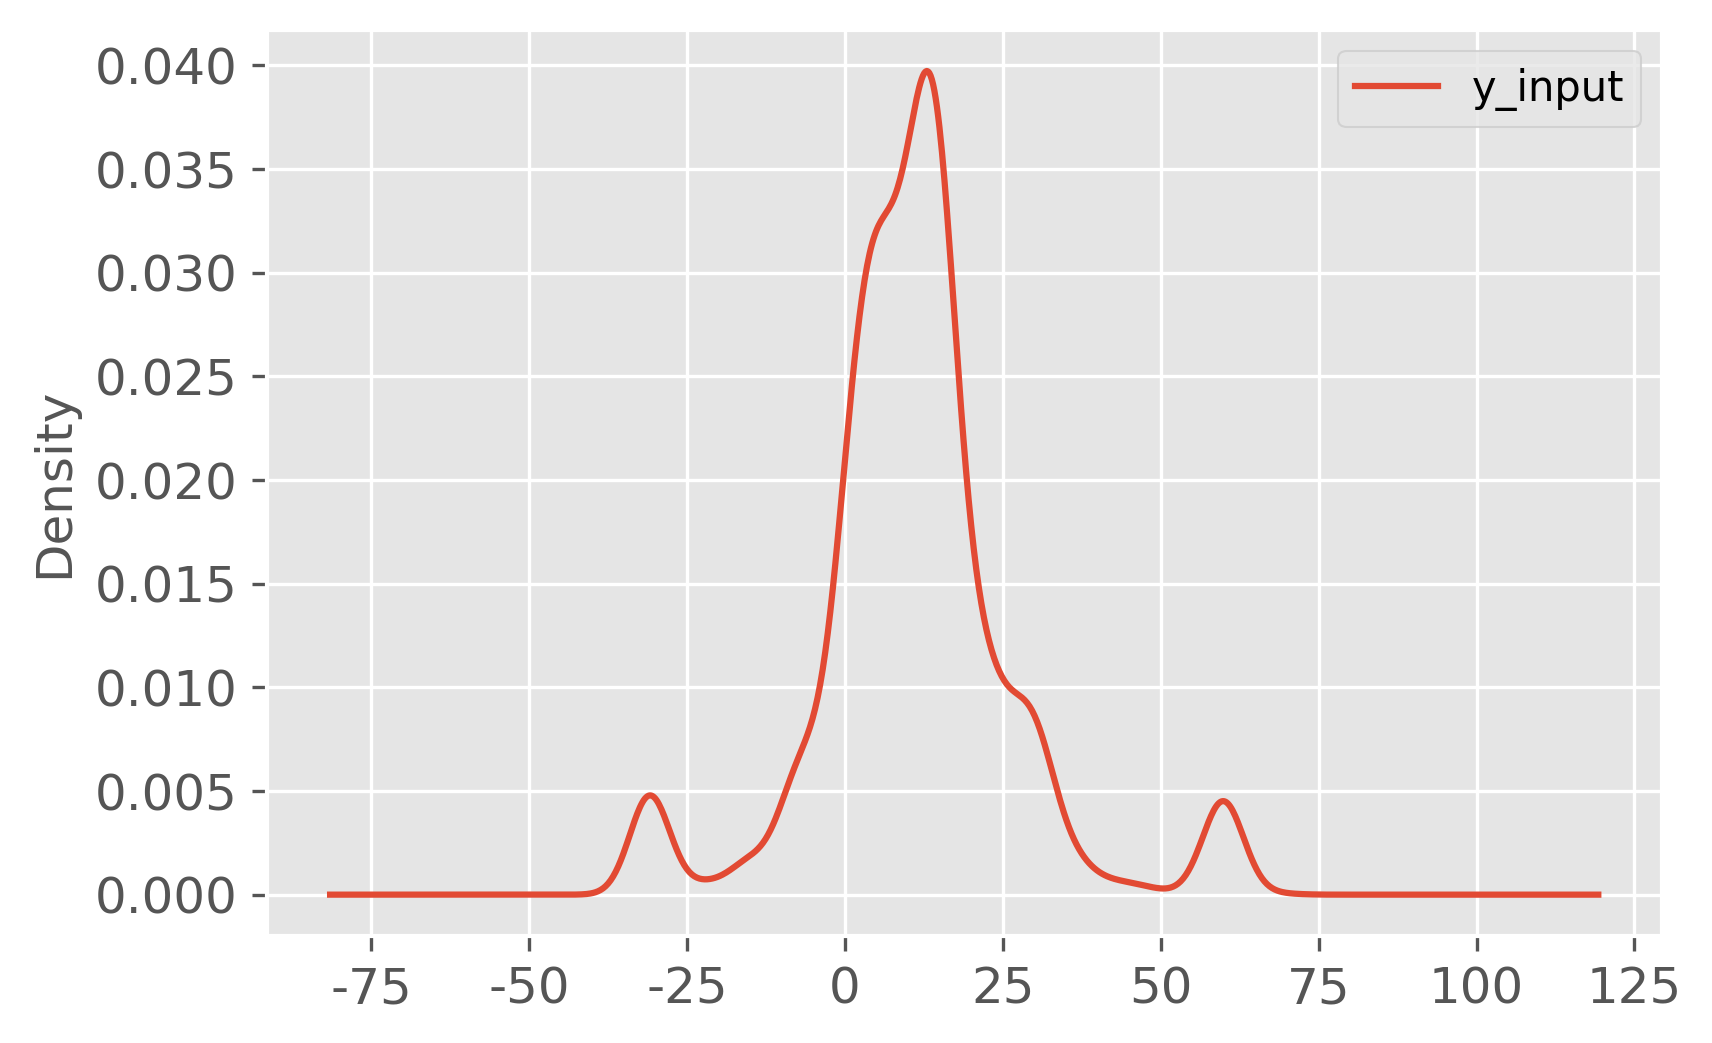

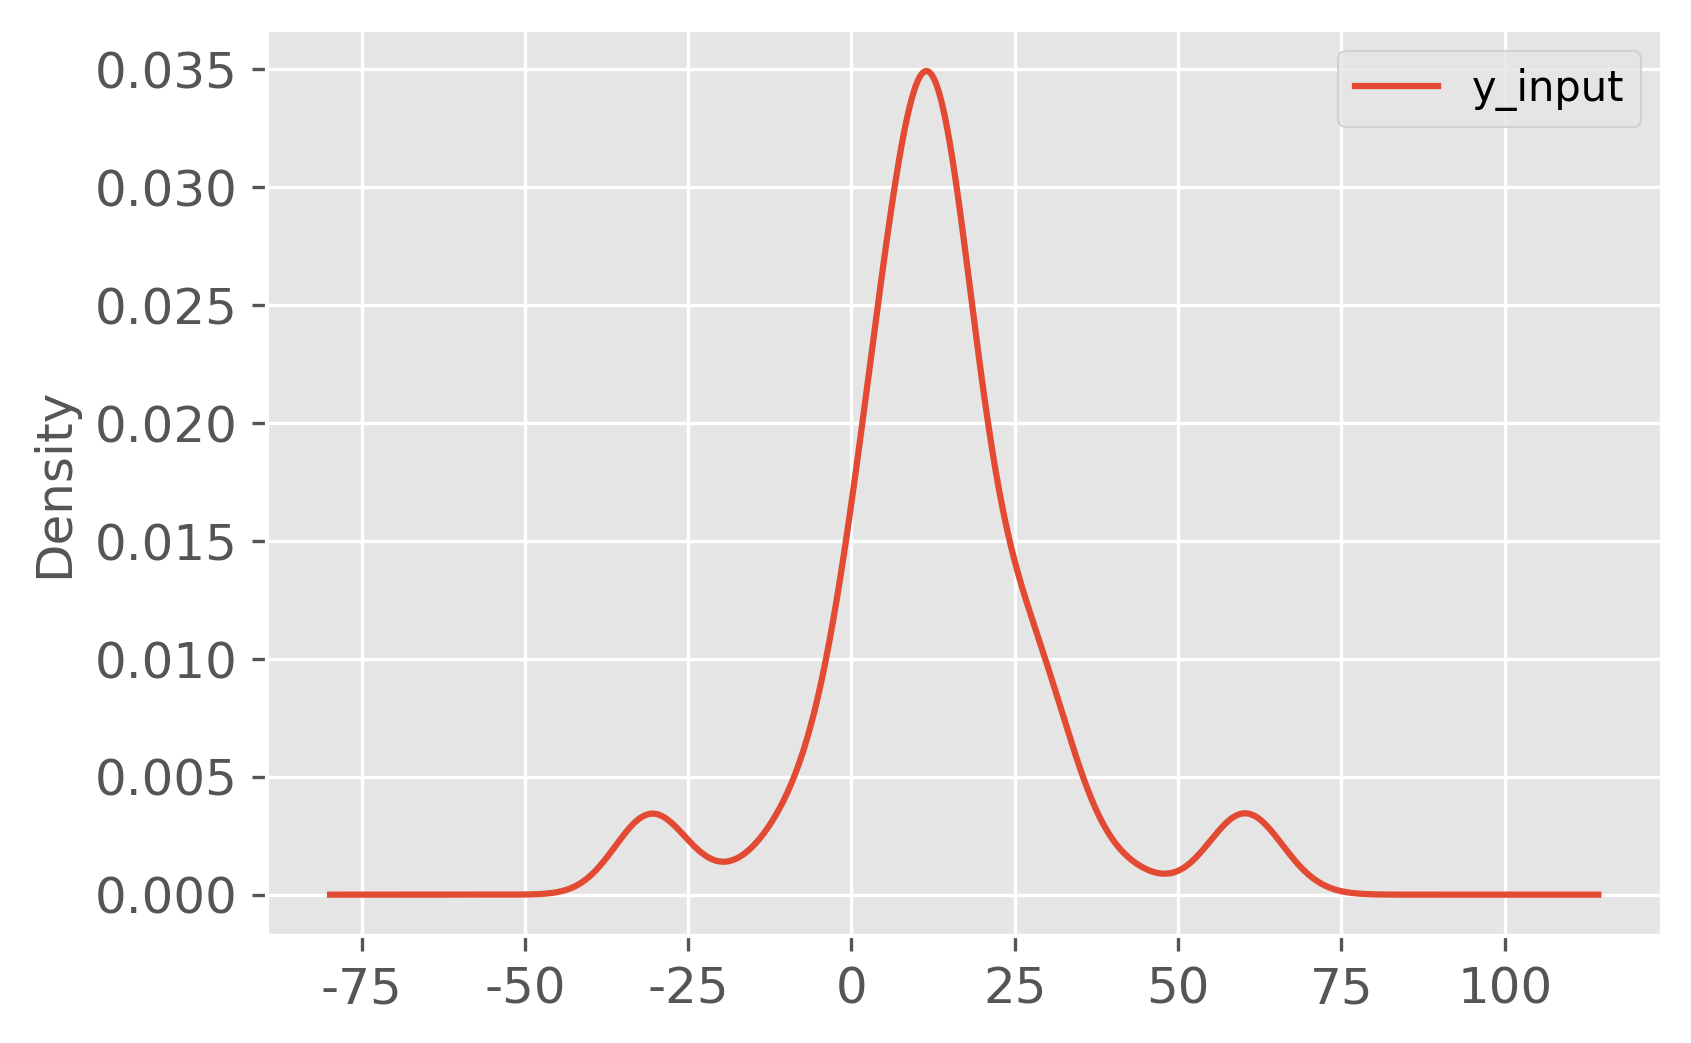

In [1670]:
test_data_all[test_data_all['y']==0][['y_input']].plot.kde()
test_data_all[test_data_all['y']==1][['y_input']].plot.kde()

(-40, 80)

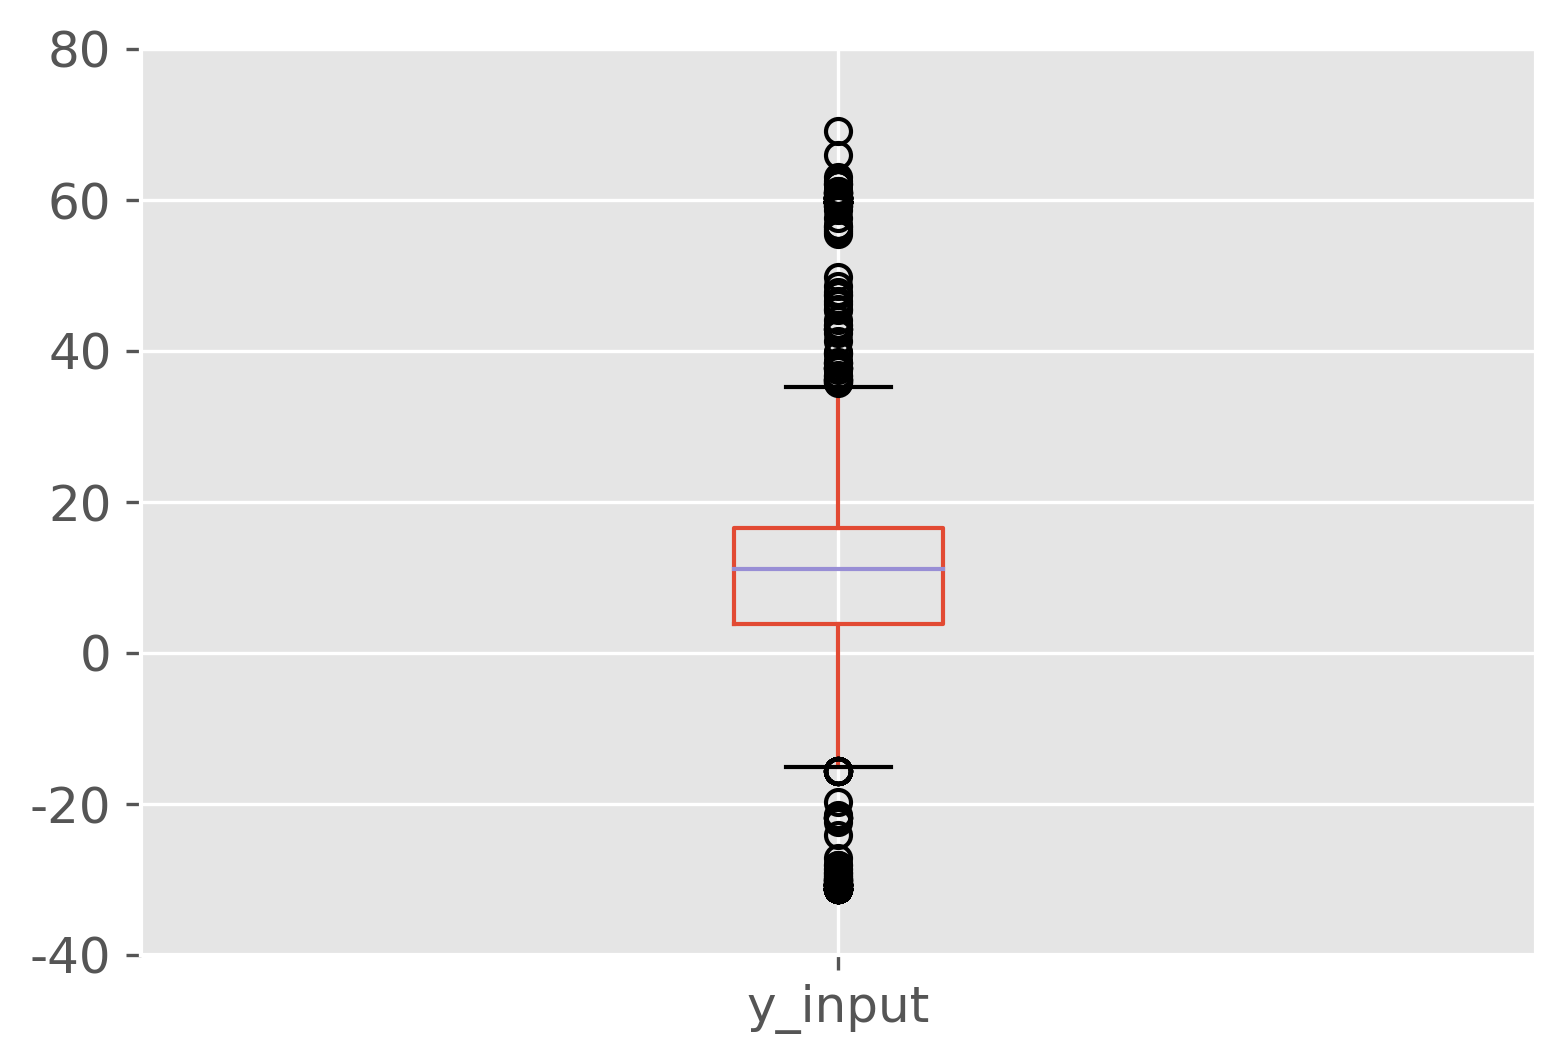

In [1665]:
test_data_all[test_data_all['y']==0][['y_input']].boxplot()
plt.ylim(-40, 80)

(0, 0.6)

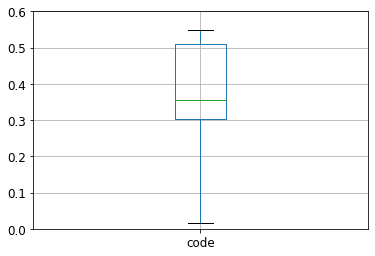

In [1464]:
code_test_all[code_test_all['y']==1][['code']].boxplot()
plt.ylim(0, 0.6)

(-40, 80)

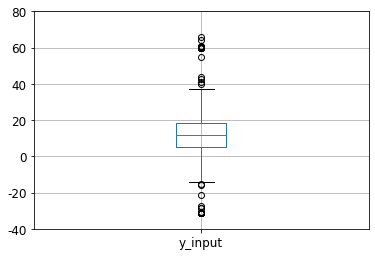

In [1462]:
test_data_all[test_data_all['y']==1][['y_input']].boxplot()
plt.ylim(-40, 80)

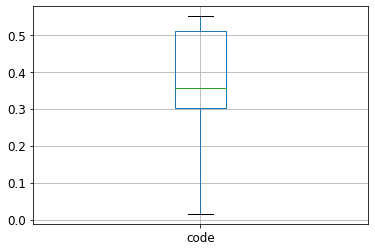

In [1434]:
code_test_all[code_test_all['y']==1][['code']].boxplot()

In [1336]:
# 검증용
for fold_num in range(0,5):
    merge_train_test_df = code_train_list[fold_num].rename(columns={'y': 'y1'})\
        .merge(create_y_merge_df('train', fold_num+1, 100).rename(columns={'y': 'y2'}), how='outer')
    print(fold_num, sum(merge_train_test_df['y1'] == merge_train_test_df['y2']),
          len(merge_train_test_df), len(code_train_list[fold_num]), len(create_y_merge_df('train', fold_num+1, 100)))
for fold_num in range(0,5):
    merge_test_test_df = code_test_list[fold_num].rename(columns={'y': 'y1'})\
        .merge(create_y_merge_df('test', fold_num+1, 100).rename(columns={'y': 'y2'}), how='outer')
    print(fold_num, sum(merge_test_test_df['y1'] == merge_test_test_df['y2']),
          len(merge_test_test_df), len(code_test_list[fold_num]), len(create_y_merge_df('test', fold_num+1, 100)))

0 3137 3137 3137 3137
1 3137 3137 3137 3137
2 3138 3138 3138 3138
3 3138 3138 3138 3138
4 3138 3138 3138 3138
0 785 785 785 785
1 785 785 785 785
2 784 784 784 784
3 784 784 784 784
4 784 784 784 784


In [1248]:
for method_num in range(len(model_dict)):
    print(fold_train_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_train_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_train_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_train_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_train_result]):.6f}')

Logistic Ridge
accuracy: 0.707290
precision: 0.169512
recall: 0.593688
f1: 0.263437
Logistic Lasso
accuracy: 0.706334
precision: 0.170255
recall: 0.600319
f1: 0.264998


In [1140]:
for method_num in range(len(model_dict)):
    print(fold_test_result[0][method_num][0])
    print(f'accuracy: {np.mean([x[method_num][1] for x in fold_test_result]):.6f}')
    print(f'precision: {np.mean([x[method_num][2][0][1] for x in fold_test_result]):.6f}')
    print(f'recall: {np.mean([x[method_num][2][1][1] for x in fold_test_result]):.6f}')
    print(f'f1: {np.mean([x[method_num][2][2][1] for x in fold_test_result]):.6f}')
    print(f'auc: {np.mean([x[method_num][3] for x in fold_test_result]):.6f}')

Logistic Ridge
accuracy: 0.666242
precision: 0.093750
recall: 0.444444
f1: 0.154839
auc: 0.576620
Logistic Lasso
accuracy: 0.664968
precision: 0.093385
recall: 0.444444
f1: 0.154341
auc: 0.576620
